# Advertising campaign - analysis of the effectiveness
***We will find reasons for the low ROI of the latest campaigns over the past few months***


We have data about users acquired from May 1 to October 27, 2019:
- The server logs with their visits data,
- Their purchases during this period,
- Advertising expenses log.

We need to answer following questions:
- Where did our users come from and what devices did they use
- How much does it cost to attract users from various advertising channels
- How much money each client brings
- When the costs of attracting a client pays off (break-even points)
- What factors affect customers aquisition and retention.

In [93]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def line():
    print('-----------------------------------------------------')
    return None

## Import data and analyze structure

In [94]:
# Importing data from files

visits =pd.read_csv('visits_info_short.csv') 
orders = pd.read_csv('orders_info_short.csv')  
costs = pd.read_csv('costs_info_short.csv') 

display(visits.head(2))
line()
display(visits.info())
line()

display(orders.head(2))
line()
display(orders.info())
line()

display(costs.head(2))
line()
display(costs.info())
line()

User Id         Region  Device  Channel        Session Start  \
0  981449118918  United States  iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States  iPhone  organic  2019-05-01 04:46:31   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35

-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

-----------------------------------------------------


User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99

-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

-----------------------------------------------------


dt   Channel  costs
0  2019-05-01  Facebook  113.3
1  2019-05-02  Facebook   78.1

-----------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

-----------------------------------------------------


**File with user visits**
- 309901 records, no missing values, data on the beginning and end of the session in the format of the text, must be converted to DateTime

**File with user orders**
- 40212 records, no missing values, data about the time in the format of the text, must be converted to DateTime

**File with advertising costs**
- 1800 records, no missing values, data about time in the format of the text, must be converted to Datetime

Also column names have to be properly formatted (no spaces and capital letters)

### Let's convert dates to DateTime, correct column names and check data for duplicates

Also let's make separate columns from date to get year, month, week, date and duration of the visit

In [95]:
# Converting column names to lowercase and replacing spaces 

visits.columns = visits.columns.str.strip().str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.strip().str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.strip().str.lower().str.replace(' ', '_')


# Checking for full duplicates
print(visits.duplicated().sum())
print(orders.duplicated().sum())
print(costs.duplicated().sum())

# Let's check for partial duplicates
print(visits.duplicated(['user_id','session_start']).sum())
print(orders.duplicated(['user_id','event_dt']).sum())

# Data on visits: Converting dates to datetime and making a year, month, week and date as separate columns
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

# Let's extract year, month, week and day of the beginning of the session and its duration in seconds
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.isocalendar().week
visits['session_date'] = visits['session_start'].dt.date
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds

# Data on activity: Converting dates to datetime and making a year, month, week and date as separate columns
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
orders['event_dt_year'] = orders['event_dt'].dt.year
orders['event_dt_month'] = orders['event_dt'].dt.month

# Data on advertising costs: Converting dates to datetime and making a year, month, week and date as separate columns
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs['dt_month'] = pd.to_datetime(costs['dt']).dt.month
costs['dt_week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week

print(visits.info())
line()

print(orders.info())
line()

print(costs.info())
line()

0
0
0
0
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   user_id               309901 non-null  int64         
 1   region                309901 non-null  object        
 2   device                309901 non-null  object        
 3   channel               309901 non-null  object        
 4   session_start         309901 non-null  datetime64[ns]
 5   session_end           309901 non-null  datetime64[ns]
 6   session_year          309901 non-null  int32         
 7   session_month         309901 non-null  int32         
 8   session_week          309901 non-null  UInt32        
 9   session_date          309901 non-null  object        
 10  session_duration_sec  309901 non-null  int32         
dtypes: UInt32(1), datetime64[ns](2), int32(3), int64(1), object(4)
memory usage: 21.6+ MB
None
----------------

There were no complete or partial duplicates, columns were renamed, the dates are in correct format now

### Functions for calculation and analysis of LTV, ROI, Retention and Conversion.

These are functions for calculating maing marketing metric:

- `get_profiles ()` - to create user profiles,
- `get_retenation ()` - for the calculation of reteniontion rate,
- `get_conversion ()` - to calculate the conversion,
- `get_ltv ()` - for calculating LTV.

As well as functions for building graphs:

- `filter_data ()` - to smooth out data,
- `plot_retention ()` - to build a schedule reteniontion rate,
- `plot_conversion ()` - to build a conversion schedule,
- `plot_ltv_roi` - for visualization LTV and ROI.

In [96]:
# Function for creating user profiles

def get_profiles(sessions, orders, ad_costs):

# Find the parameters of the first visits
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

# For cohort analysis, we will user the date of the first visit
# and the first day of the month on which this visit has happened
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].dt.to_period('M')

# Adding a flag of a paying users
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

# Count the number of unique users
# with the same source and first visit date
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

# Let's combine expenses for advertising and the number of attracted users
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

# ...and divide advertising costs by the number of attracted users to get CAC (Customer acquisitin cost)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

# Adding CAC to profiles
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

# The CAC for organic users is zero
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [97]:
# Function for retention calculation

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

# Add Payer column to Dimension List
    dimensions = ['payer'] + dimensions

# Exclude users who have not "survived" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

# We collect "raw" data for the calculation of retention
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

# Function for grouping table by the desired dimentions
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

# Here comes a retention table
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

# ... and a table of retention dynamics
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

# Returning both tables and raw data
    return result_raw, result_grouped, result_in_time

In [98]:

# Function for conversion calculation

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

# Excluding users who have not "survived" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

# Defining the date and time of the first purchase for each user
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

# Adding purchases to profiles
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

# Calculating lifetime for each purchase in days
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

# Grouping by cohort, if there is nothing else in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

# Function for grouping table by the desired dimensions
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

# Dividing each cell by the size of the cohort to get conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

# For the table of conversion dynamics, we remove cohorts from dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

# Return both tables and raw data
    return result_raw, result_grouped, result_in_time

In [99]:
# Function for LTV and ROI calculation

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

# Excluding users who have not "survived" to the analysis horizon
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - dt.timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

# Adding purchases to profiles
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
# Calculating lifetime of the user for each purchase
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
# Grouped by cohort, if there is nothing else in dimensions
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

# The function for grouping on the desired dimensions
    def group_by_dimensions(df, dims, horizon_days):

# Building a "triangular" revenue table
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
# Find the cumulative revenue
        result = result.fillna(0).cumsum(axis=1)
# Calculate the sizes of cohort
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
# Combining sizes of cohort and the revenue table
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
# LTV: Dividing each "cell" in a line by the size of the cohort
        result = result.div(result['cohort_size'], axis=0)
# Excluding all lifetema that exceed the horizon of analysis
        result = result[['cohort_size'] + list(range(horizon_days))]
# Restore the sizes of cohort
        result['cohort_size'] = cohort_sizes

# Building a datafrem with user data and CAC values, 
# adding parameters from dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

# Counting the average CAC for parameters from dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

# ROI: Divide LTV by CAC
        roi = result.div(cac['cac'], axis=0)

# Remove lines with endless ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

# Restore the sizes of cohort in the ROI table
        roi['cohort_size'] = cohort_sizes

# Add CAC to the ROI table
        roi['cac'] = cac['cac']

# In the final table we leave the sizes of cohort, CAC
# and ROI if lifetime not exceeding the horizon of analysis
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

# Return the LTV and ROI tables
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

# For tables of dynamics, remove cohorts from Dimensions
    if 'cohort' in dimensions:
        dimensions = []

# Here we have dynamics tables for LTV and ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # raw data
        result_grouped,  # table LTV
        result_in_time,  # Dynamics table LTV
        roi_grouped,  # table ROI
        roi_in_time,  # Table of ROI Dynamics
    )

In [100]:
# Frame smoothing function

def filter_data(df, window):
    # for each column we use a sliding average
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [101]:
# Function for visualization of retention

def plot_retention(retention, retention_history, horizon, window=7):

    # Set the size of the grid for graphs
    plt.figure(figsize=(15, 10))

    # Eliminate the size of cohort and keeping the first day
    retention = retention.drop(columns=['cohort_size', 0])
    # In dynamics table we leave only needed lifetime
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # If in the indexes of the retention table only Payer,
    # Add the second dimension - COHORT
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # In the table of graphs - two columns and two lines, four cells
    # In the first we build graph of paying users
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention paying users')

    # In the second cell, we build graph of non -paying
    # Vertical axis - from the first cell
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Retention non -paying users')

    # Third cell - retention dynamics of payers
    ax3 = plt.subplot(2, 2, 3)
    # Names of columns for a summary table
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # Filter data and build a graph
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of acquisition')
    plt.title(
        'The dynamics of retention paying users on {}'.format(
            horizon
        )
    )

    # Retention dynamics of non -payers
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # filter data and build a graph
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Date of acquisition')
    plt.title(
        'The dynamics of retention of non-paying users on {}'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [102]:
# Function for visualization of conversion

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # Set the size of the grid for graphs
    plt.figure(figsize=(15, 5))

    # Exclude the size of the cohort
    conversion = conversion.drop(columns=['cohort_size'])
    # In the Dynamics table we leave only the desired lifetime
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('Users conversion')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('The dynamics of user conversion on {}'.format(horizon))

    plt.tight_layout()
    plt.show()

In [103]:
# Visualization function for LTV and ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    # From the LTV table, we exclude the size of the cohort
    ltv = ltv.drop(columns=['cohort_size'])
    # Leaving only needed lifetime
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    # From the ROI table, we exclude the sizes of cohort and CAC
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # In the ROI dynamics table, we leave only the desired lifetime
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # The first plot is LTV
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # The second plot is LTV dynamics
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # all columns of the index, except for the date
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Date of acquisition')
    plt.title('Dynamics LTV users on {}'.format(horizon))

    # The third plot is CAC dynamics
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # all columns of the index, except for the date
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Date of aquisition')
    plt.title('Dynamics of the cost of acquisition users')

    # Fourth plot - ROI curves
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='ROI')
    plt.legend()
    plt.xlabel('Lifetime')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # all columns of the index, except for the date
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='The pay-off level')
    plt.xlabel('Date of acquisition')
    plt.title('The dynamics of ROI users on {}'.format(horizon))

    plt.tight_layout()
    plt.show()

## Research Analysis of Data

### Let's make user profiles

In [104]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))

user_id            first_ts   channel  device         region          dt  \
0    599326 2019-05-07 20:58:57  Facebook     Mac  United States  2019-05-07   
1   4919697 2019-07-09 12:46:07  Facebook  iPhone  United States  2019-07-09   
2   6085896 2019-10-01 09:58:33   organic  iPhone         France  2019-10-01   
3  22593348 2019-08-22 21:35:48   AdSense      PC        Germany  2019-08-22   
4  31989216 2019-10-02 00:07:44   YRabbit  iPhone  United States  2019-10-02   

     month  payer  acquisition_cost  
0  2019-05   True          1.088172  
1  2019-07  False          1.107237  
2  2019-10  False          0.000000  
3  2019-08  False          0.988235  
4  2019-10  False          0.230769

### Let's look at the data distribution

Median costs for acquisition (including users who came without advertising): 0.25


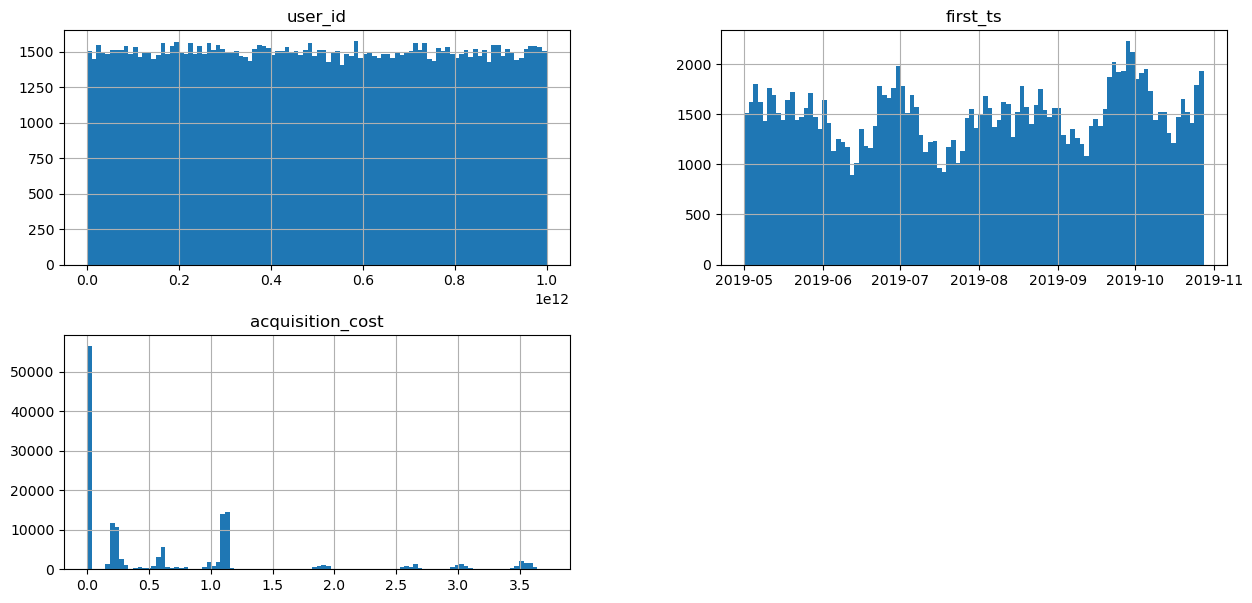

In [105]:
profiles.hist(bins=100, figsize=(15,7));

print('Median costs for acquisition (including users who came without advertising): {:.2f}'.format(profiles['acquisition_cost'].median()))

**Initial observations:**
- Dynamics of the number of acquired users (first_ts) shows seasonal fluctuations - in the middle of each month we observe the drop, which can be associated with the dynamics of advertising campaigns
- The number of users who came in June-July period is significantly less than May figures. In August-September, the number returned to May values, but in October it fell again.
- The median value of the cost of acquisition, including "organic" users - 0.25
- Most customers (about 60,000) came from the Organic channel
- The next large peak in the cost of acquisition - about 1
- There are a fairly big number of customers with cost of acquisition 10x times higher than median

Let's look at the distribution of costs for acquisition more closely: excluding organic users from the analysis



Median costs for acquisition (for advertising): 1.08


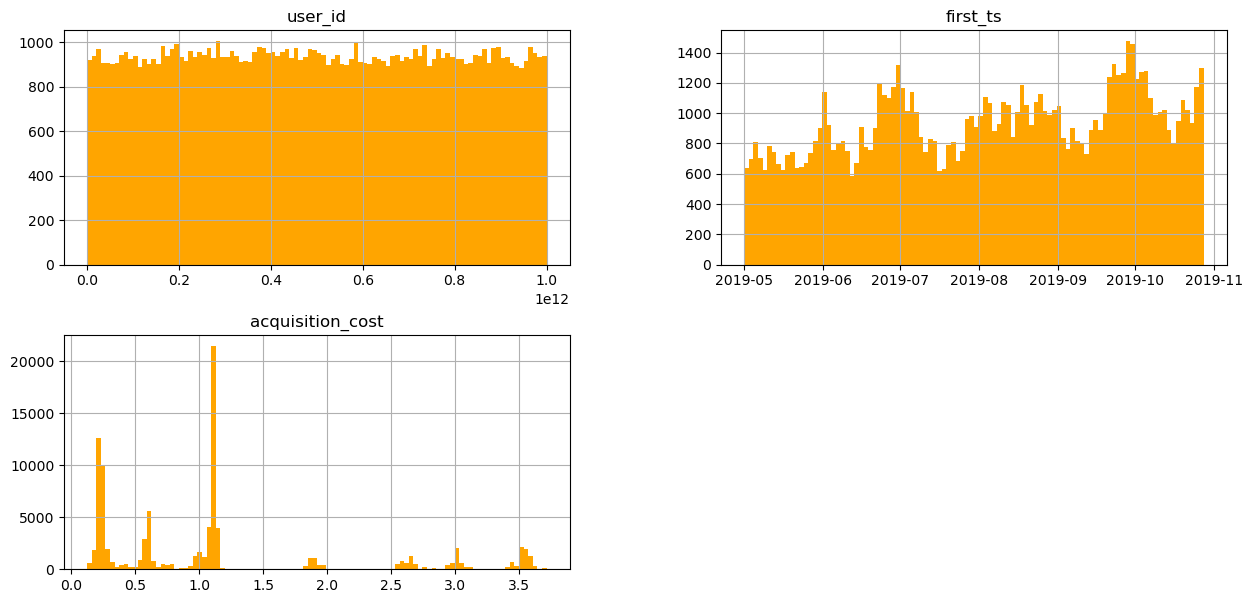

In [106]:
print('Median costs for acquisition (for advertising): {:.2f}'.format(profiles.loc[profiles['channel']!='organic', 'acquisition_cost'].median()))

profiles.query('acquisition_cost>0').hist(bins=100, figsize=(15,7), color='orange');


- Seasonal fluctuations for user acquisition is also present - in the middle of each month we observe drops
- Most of the acquisition costs are in 0.25 - 1.25 range


### Let's see if there are any differences in seasonal fluctuations in acquiring organic and paid users

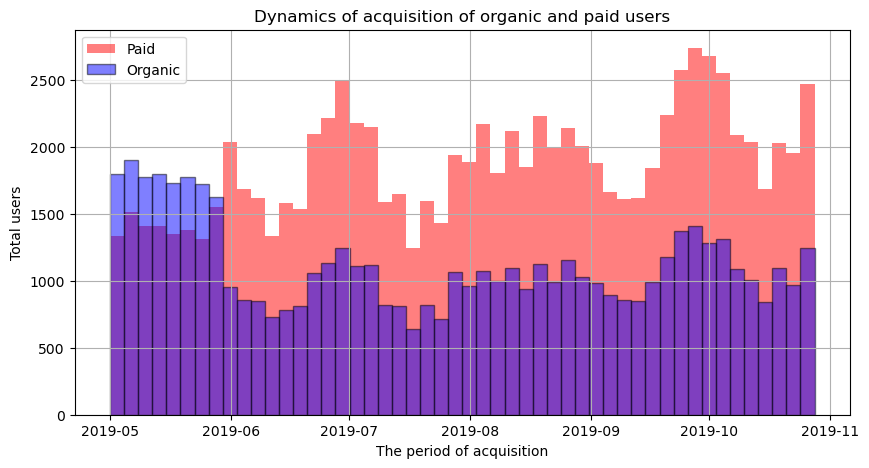

In [107]:
profiles_organic = profiles.query('channel == "organic"')
profiles_ad = profiles.query('channel != "organic"')

plt.figure(figsize=(10, 5))

profiles_ad['first_ts'].hist(bins=50, color='red', alpha=0.5, label='Paid')
profiles_organic['first_ts'].hist(bins=50, color='blue', alpha=0.5, edgecolor='black', label='Organic')

# Set up the axis and add legends
plt.ylabel('Total users')
plt.xlabel('The period of acquisition')
plt.legend(loc='upper left')

# Add the title
plt.title('Dynamics of acquisition of organic and paid users')

plt.show()

- A seasonal fluctuations in organic users acquisition repeat repeats for paid
- A curious moment: in May, aquisition of organic users was higher than acquisition of paid but from the beginning of June it fell sharply.This is probably a result of the beginning of an aggressive advertising campaign

### Let's get the minimum and maximum dates of attracting users

In [108]:
print('The minimum date of acquisition: {}'.format(profiles['first_ts'].min().date()))
print('The maximum date of acquisition: {}'.format(profiles['first_ts'].max().date()))

The minimum date of acquisition: 2019-05-01
The maximum date of acquisition: 2019-10-27


### Let's find out from which countries users come to the application and which country has more paying users

payer          non_payer  payer  country_total  ratio_%
region                                                 
France             16787    663          17450     3.80
Germany            14365    616          14981     4.11
UK                 16875    700          17575     3.98
United States      93100   6902         100002     6.90


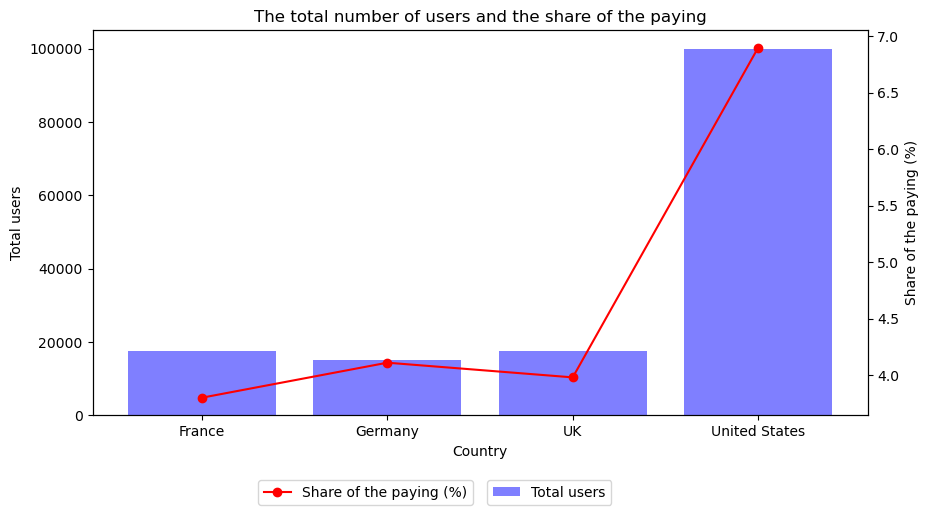

In [109]:
payer_by_country = pd.pivot_table(profiles, index='region', columns='payer', values='user_id', aggfunc='count')

# Rename the columns
payer_by_country = payer_by_country.rename(columns={False: 'non_payer', True: 'payer'})

# Add a column with a ratio of users who pay and who doesnt
payer_by_country['country_total'] = payer_by_country.sum(axis=1)
payer_by_country['ratio_%'] = round(payer_by_country['payer'] / payer_by_country['country_total'] * 100, 2)

print(payer_by_country)

# Build a graph
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(payer_by_country.index, payer_by_country['country_total'], color='b', alpha=0.5, label='Total users');

# Create a second axis for a share of paying users
ax2 = ax1.twinx()
ax2.plot(payer_by_country.index, payer_by_country['ratio_%'], color='r', marker='o', label='Share of the paying (%)');

# Set up the axis and add the legend
ax1.set_ylabel('Total users')
ax2.set_ylabel('Share of the paying (%)')
ax1.set_xlabel('Country')
ax1.legend(loc='upper left', bbox_to_anchor=(0.5, -0.15))
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, -0.15))

# Add the title
plt.title('The total number of users and the share of the paying')

# We display the graph
plt.show()

- The largest number of users in the USA - 100 thousand against 15-18 thousand in each of the other countries
- In the USA, the highest ratio of paying usels to their total quantity - **6.9%**
- In other countries, the share of paying users at the level of **4%**, the least paying users share is in France - **3.8%**

### Let's see the organic users percentage in each of the countries and how they're distributed among channels

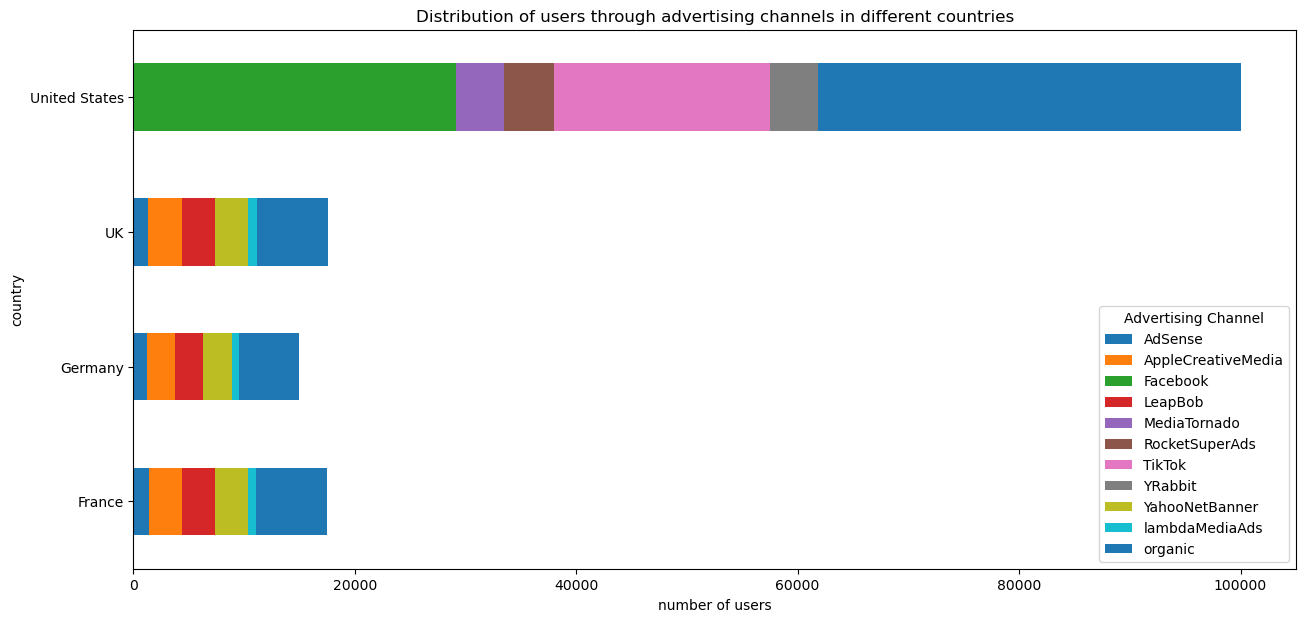

channel        AdSense  AppleCreativeMedia  Facebook  LeapBob  MediaTornado  \
region                                                                        
France          1366.0              2991.0       0.0   2988.0           0.0   
Germany         1219.0              2562.0       0.0   2519.0           0.0   
UK              1295.0              3052.0       0.0   3046.0           0.0   
United States      0.0                 0.0   29144.0      0.0        4364.0   

channel        RocketSuperAds   TikTok  YRabbit  YahooNetBanner  \
region                                                            
France                    0.0      0.0      0.0          2971.0   
Germany                   0.0      0.0      0.0          2579.0   
UK                        0.0      0.0      0.0          3003.0   
United States          4448.0  19561.0   4312.0             0.0   

channel        lambdaMediaAds  organic     total  organic_ratio  
region                                                           
France                  742.0   6392.0   17450.0          36.63  
Germany                 649.0   5453.0   14981.0          36.40  
UK                      758.0   6421.0   17575.0          36.53  
United States             0.0  38173.0  100002.0          38.17

In [110]:
organic_by_country = pd.pivot_table(profiles, index='region', columns='channel', values='user_id', aggfunc='count').fillna(0)
organic_by_country_data = pd.DataFrame(organic_by_country)

# Summarize the number of users for each channel
organic_by_country['total'] = organic_by_country_data.sum(axis=1)

# Calculate the share of users who came from an organic source
organic_by_country['organic_ratio'] = round((organic_by_country_data['organic'] / organic_by_country['total']) * 100, 2)

organic_by_country_data.plot(kind='barh', stacked=True, figsize=(15, 7))

# Setting title and signing axes
plt.title ('Distribution of users through advertising channels in different countries')
plt.xlabel ('number of users')
plt.ylabel ('country')

# The display of the legend
plt.legend(title='Advertising Channel')

# The chart display
plt.show()

display(organic_by_country)

- The proportion of organic users is approximately the same for all countries - **36-38%**, i.e. There are no anomalies
- The graph shows that the split of advertising channels for the United States differs from other countries: in the USA they use mainly **TikToc & Facebook**, while other countires use another channels

### Let's see usage for different types of devices and especcially for paying users

payer    non_payer  payer  device_total  ratio_%
device                                          
Android      32982   2050         35032     5.85
Mac          28130   1912         30042     6.36
PC           28918   1537         30455     5.05
iPhone       51097   3382         54479     6.21


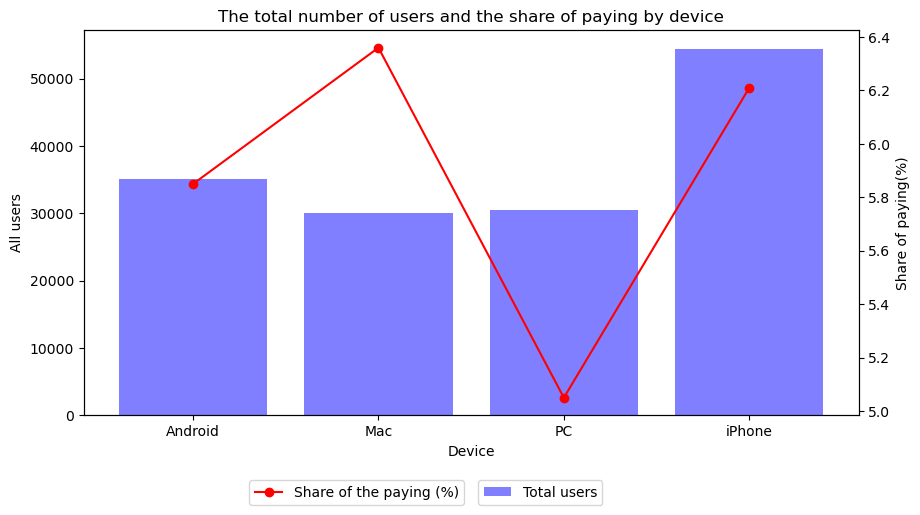

In [111]:
payer_by_device = pd.pivot_table(profiles, index='device', columns='payer', values='user_id', aggfunc='count')

# Rename the columns
payer_by_device = payer_by_device.rename(columns={False: 'non_payer', True: 'payer'})

# Add a column with a ratio of users who pay and who does not pay
payer_by_device['device_total'] = payer_by_device.sum(axis=1)
payer_by_device['ratio_%'] = round(payer_by_device['payer'] / payer_by_device['device_total'] * 100, 2)

print(payer_by_device)

# Build a graph for clarity
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.bar(payer_by_device.index, payer_by_device['device_total'], color='b', alpha=0.5, label='Total users');

# Create a second axis for a share of paying users
ax2 = ax1.twinx()
ax2.plot(payer_by_device.index, payer_by_device['ratio_%'], color='r', marker='o', label='Share of the paying (%)');

# Set up the axis and add the legend
ax1.set_ylabel ('All users')
ax2.set_ylabel ('Share of paying(%)')
ax1.set_xlabel ('Device')
ax1.legend(loc = 'upper left', bbox_to_anchor = (0.5, -0.15))
ax2.legend(loc = 'upper right', bbox_to_anchor = (0.5, -0.15))

# Add the title
plt.title('The total number of users and the share of paying by device')

plt.show()

- First by quantity - iPhone users, 54.5 thousand, of which **6.21%** - paying
- Second by quantity - Android users, 35 thousand, of which **5.85%** - paying
- Mac and PC are approximately equal in terms of user count - 30 thousand, but Mac has more paying-  **6.36%**, against **5.05%** on PC 

### Let's examine advertising sources to know where paying users are coming from

-----------------------------------------------------
Avg percentage of payers: 5.92


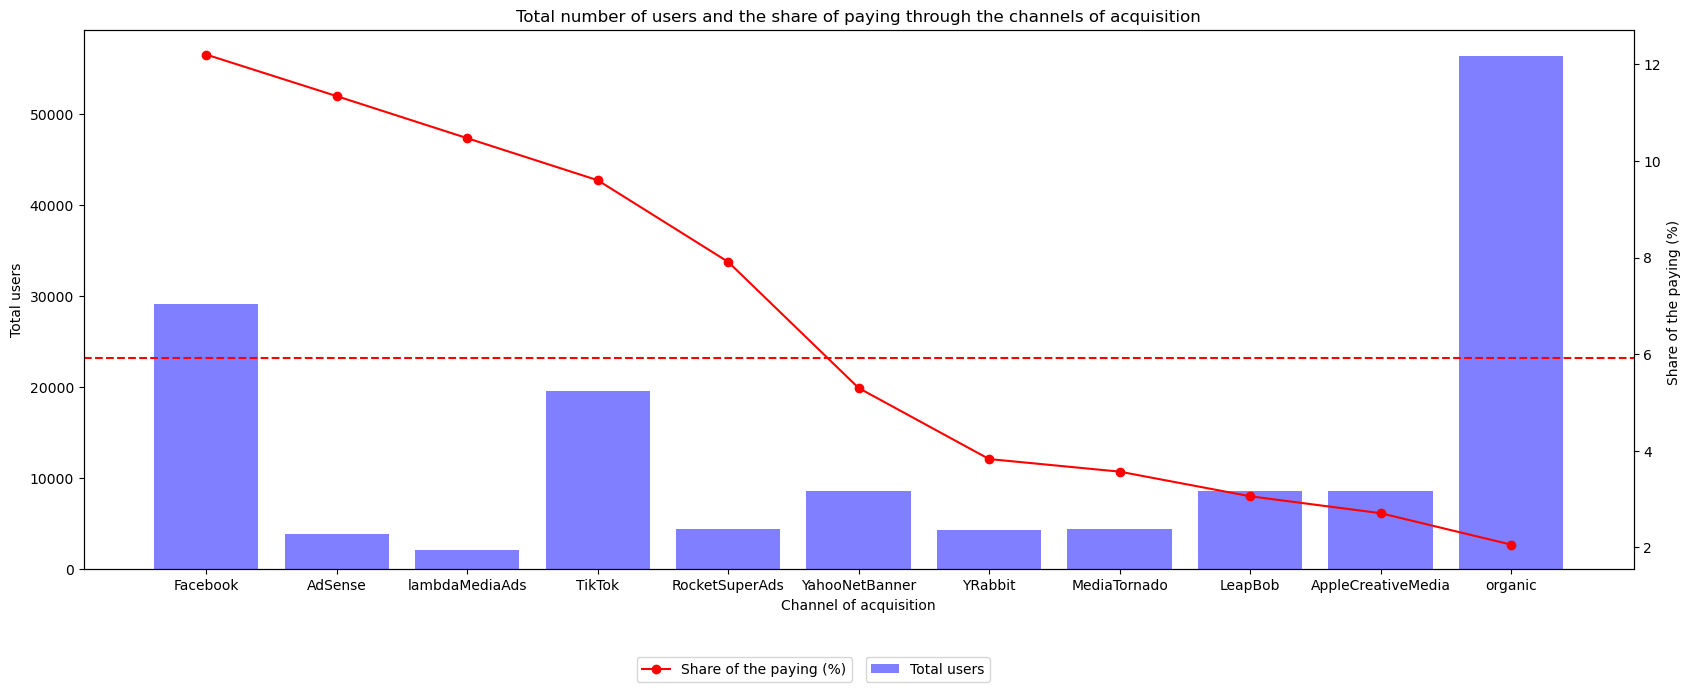

payer               non_payer  payer  channel_total  ratio_%
channel                                                     
Facebook                25587   3557          29144    12.20
AdSense                  3440    440           3880    11.34
lambdaMediaAds           1924    225           2149    10.47
TikTok                  17683   1878          19561     9.60
RocketSuperAds           4096    352           4448     7.91
YahooNetBanner           8100    453           8553     5.30
YRabbit                  4147    165           4312     3.83
MediaTornado             4208    156           4364     3.57
LeapBob                  8291    262           8553     3.06
AppleCreativeMedia       8372    233           8605     2.71
organic                 55279   1160          56439     2.06

In [112]:
payer_by_channel = pd.pivot_table(profiles, index='channel', columns='payer', values='user_id', aggfunc='count')

# Rename the columns
payer_by_channel = payer_by_channel.rename(columns={False: 'non_payer', True: 'payer'})

# Add a column with a ratio of users who pay and do not pay
payer_by_channel['channel_total'] = payer_by_channel.sum(axis=1)
payer_by_channel = payer_by_channel.sort_values(by='channel_total', ascending=False)
payer_by_channel['ratio_%'] = round(payer_by_channel['payer'] / payer_by_channel['channel_total'] * 100, 2)
payer_by_channel.sort_values(by='ratio_%', ascending=False, inplace=True)

line()
print('Avg percentage of payers: {:.2f}'.format(payer_by_channel['payer'].sum() / payer_by_channel['channel_total'].sum()* 100))


# Build a chart for clarity
fig, ax1 = plt.subplots(figsize=(20, 7))

ax1.bar(payer_by_channel.index, payer_by_channel['channel_total'], color='b', alpha=0.5, label='Total users');

# Create a second axis for a share of paying users
ax2 = ax1.twinx()
ax2.plot(payer_by_channel.index, payer_by_channel['ratio_%'], color='r', marker='o', label='Share of the paying (%)');

# Set up the axis and add the legend
ax1.set_ylabel('Total users')
ax2.set_ylabel('Share of the paying (%) ')
ax1.set_xlabel('Channel of acquisition')
ax1.legend(loc='upper left', bbox_to_anchor=(0.5, -0.15))
ax2.legend(loc='upper right', bbox_to_anchor=(0.5, -0.15))

# Adding a red dashed line at the level of the average share of payers (5.92%)
ax2.axhline(y=5.92, color='red', linestyle='--')

# Add the title
plt.title('Total number of users and the share of paying through the channels of acquisition')

plt.show()

display(payer_by_channel)

- The average percentage of paying users among all  / all channels - *5.92%**
- Most users came without advertising - the Organic channel, 56 thousand, but at the same time, the share of paying among them is the lowest: **2.06%**
- Second place is the Facebook channel, almost 30 thousand users and the share of paying is the highest among all channels - **12.2%**
- Third place is the TikToc with 20 thousand users. The share of the paying is also high - **9.6%**
- The rest of the channels show modest results both in the number of acquired users (2-9 thousand) and the percentage of payers (less **4%** )
- Among the smallest by the nymber of acquired users, AdSense and Lambdamediaads have higher-than-average paying share -  more than **10%**.  

### Let's calculate the total amount of marketing costs and its distribution among advertising sources

Total amount of marketing costs: 105497
-------------------------------------
channel
TikTok                51.898295
Facebook              30.754910
YahooNetBanner         4.882589
AdSense                3.707441
AppleCreativeMedia     2.039152
RocketSuperAds         1.737485
LeapBob                1.703930
lambdaMediaAds         1.476436
MediaTornado           0.904744
YRabbit                0.895018
Name: costs, dtype: float64


channel  total_costs  percent_from_total  revenue_by_user  \
7              YRabbit       944.22            0.895018          6201.43   
5       RocketSuperAds      1833.00            1.737485         11598.32   
4         MediaTornado       954.48            0.904744          5752.32   
9       lambdaMediaAds      1557.60            1.476436          8941.70   
3              LeapBob      1797.60            1.703930          9560.13   
1   AppleCreativeMedia      2151.25            2.039152          8365.53   
8       YahooNetBanner      5151.00            4.882589         20006.63   
6               TikTok     54751.30           51.898295         69574.76   
0              AdSense      3911.25            3.707441          3697.17   
2             Facebook     32445.60           30.754910         25637.66   
10             organic         0.00            0.000000         46627.23   

     ratio  
7   656.78  
5   632.75  
4   602.67  
9   574.07  
3   531.83  
1   388.87  
8   388.40  
6   127.07  
0    94.53  
2    79.02  
10    0.00

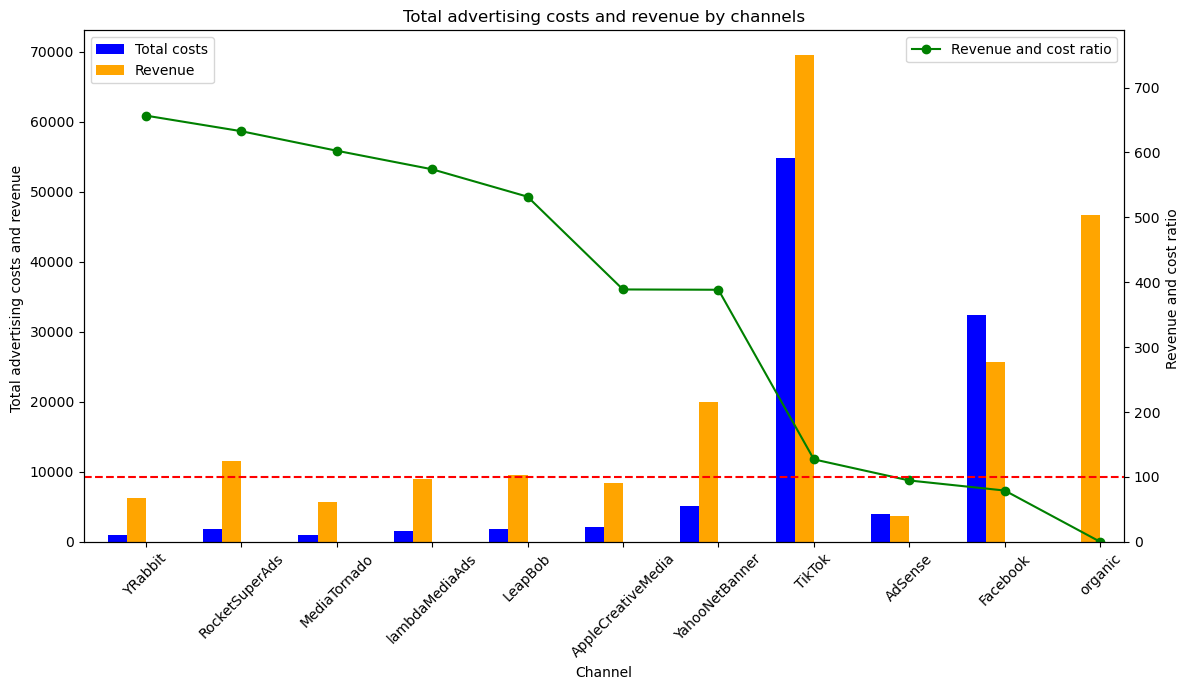

In [113]:

total_ad_cost_by_channel = costs.groupby('channel')['costs'].sum().sort_values(ascending=False)

total_costs = total_ad_cost_by_channel.sum()

print ('Total amount of marketing costs:', round (total_costs))
print('-------------------------------------')

# Calculate the percentage of the total amount for each channel
percent_from_total = total_ad_cost_by_channel / total_costs * 100
print(percent_from_total)

# Create a new Dataframe with results
ad_costs = pd.DataFrame({
    'channel': total_ad_cost_by_channel.index,
    'total_costs': total_ad_cost_by_channel.values,
    'percent_from_total': percent_from_total.values
})

# Lets calculate the ratio of the total advertising costs for the channel and revenue from users who came from these channels
# First calculate the total Revenue for each user
revenue_by_user_data = orders.groupby('user_id').agg({'revenue':'sum'})
revenue_by_user = pd.DataFrame(revenue_by_user_data)

# Merge of Revenue data by user_id with user profiles data
profiles = pd.merge(profiles, revenue_by_user, on='user_id', how='left').fillna(0)
profiles.rename(columns={'revenue': 'revenue_by_user'}, inplace=True)

# Now lets calculate Revenue in relation to the channels where the users came from
revenue_by_channel_data = profiles.groupby('channel').agg({'revenue_by_user':'sum'})
revenue_by_channel = pd.DataFrame(revenue_by_channel_data)

channel_revenue_vs_costs = pd.merge(ad_costs, revenue_by_channel, on='channel', how='right')
channel_revenue_vs_costs['ratio'] = round(channel_revenue_vs_costs['revenue_by_user'] / channel_revenue_vs_costs['total_costs'] * 100, 2)
channel_revenue_vs_costs = channel_revenue_vs_costs.sort_values(by='ratio', ascending=False).fillna(0)
display(channel_revenue_vs_costs)

# add data visualization

# Creating a figure and axes
fig, ax1 = plt.subplots(figsize=(12, 7))

channel_revenue_vs_costs[['total_costs', 'revenue_by_user']].plot(kind='bar', ax=ax1, width=0.4, position=1, color=['blue', 'orange'], legend=False)

# Setting the axes
ax1.set_ylabel('Total advertising costs and revenue ')
ax1.set_xlabel('Channel')

# Updating the xtick labels with values to avoid any implicit reference issues
ax1.set_xticklabels(channel_revenue_vs_costs['channel'].values, rotation=45)
ax1.set_title('Total advertising costs and revenue by channels')

# Creating the second axis Y for graphics with Ratio
ax2 = ax1.twinx()



ax2.plot(channel_revenue_vs_costs['channel'], channel_revenue_vs_costs['ratio'], marker='o', color='green')
# Setting the second axis Y
ax2.set_ylabel('Revenue and cost ratio ')
ax2.set_ylim(0, max(channel_revenue_vs_costs['ratio']) * 1.2)  # Installation of the limit for the second axis Y
# Setting legends for clarity in bar and line plots
ax1.legend(['Total costs', 'Revenue'], loc='upper left')
ax2.legend(['Revenue and cost ratio'], loc='upper right')

# Adding a red dashed line at the level of 100% ratio
ax2.axhline(y=100, color='red', linestyle='--')

plt.tight_layout()
plt.show()


- Red dashed horisontal line shows ROI = 100% (means our earning = our expences)
- First place in terms of costs and revenue - the TikTok channel, with ratio of - **127%** (we spent 100, we earnt 127)
- Second place by revenue is Organic channel. Advertising costs = 0
- Third place in terms of revenue is Facebook, but ROI is just - **79%**, i.e. we spend more on advertising than we earn from it.
- The remaining channels, although they show more modest revenue results, have a much higher revenue/costs ratio - **400% and higher**.
- AdSense channel is both non-profitable and low on user acquisition.    

### Let's build graphs with visualization of the metrics dynamics for each channel 

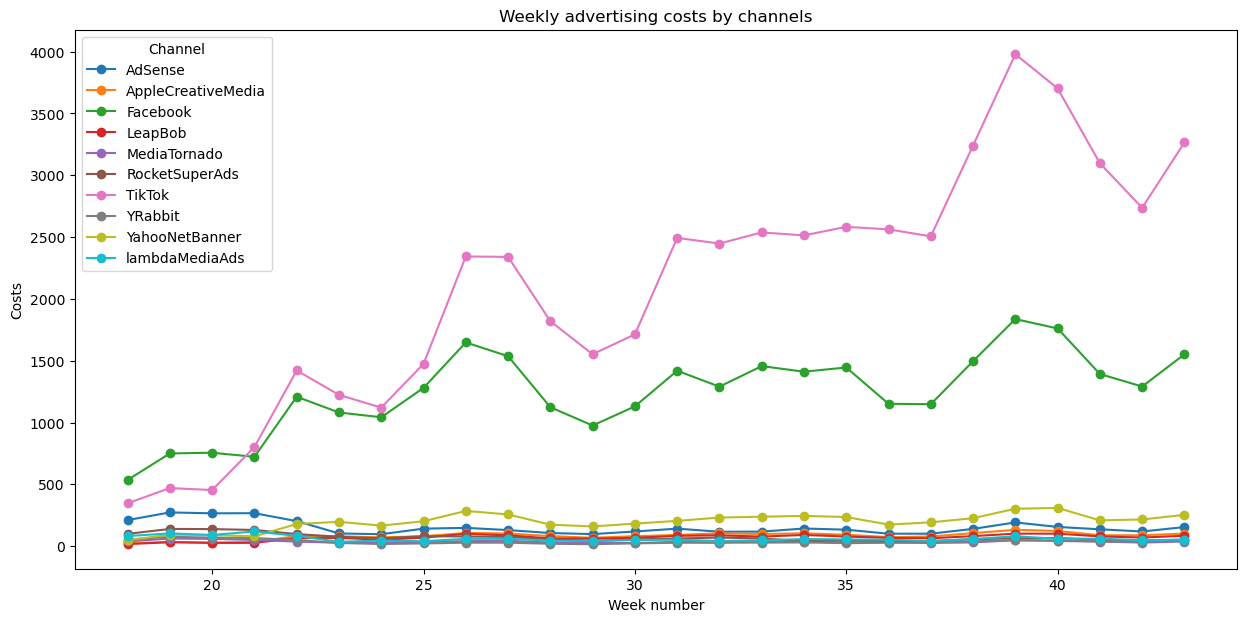

In [114]:

monthly_ad_cost_by_channel = pd.pivot_table(costs, index='channel', columns='dt_month', values='costs', aggfunc='sum').reset_index()
weekly_ad_cost_by_channel = pd.pivot_table(costs, index='channel', columns='dt_week', values='costs', aggfunc='sum').reset_index()

# Creating a graph for each channel for weekly advertising costs
fig, ax = plt.subplots(figsize=(15, 7))

for index, row in weekly_ad_cost_by_channel.iterrows():
    ax.plot(weekly_ad_cost_by_channel.columns[1:], row[1:], marker='o', label=row['channel'])

# Settings of the graphics
plt.title('Weekly advertising costs by channels')
plt.xlabel('Week number')
plt.ylabel('Costs')

# Display of the legend
plt.legend(title='Channel', loc='upper left', bbox_to_anchor=(0, 1))

plt.show()


- At the beginning of the period (the first 3 weeks), advertising costs were stable, but after they went up sharply, which may be due to the marketing tasks of new users acquisitions
- Starting from the 4th week TikTok & Facebook seems to be leaders in ads costs (probably due to chanbel prioritising)
- From the 4th week advertising costs on TikTok grow faster than any other channel

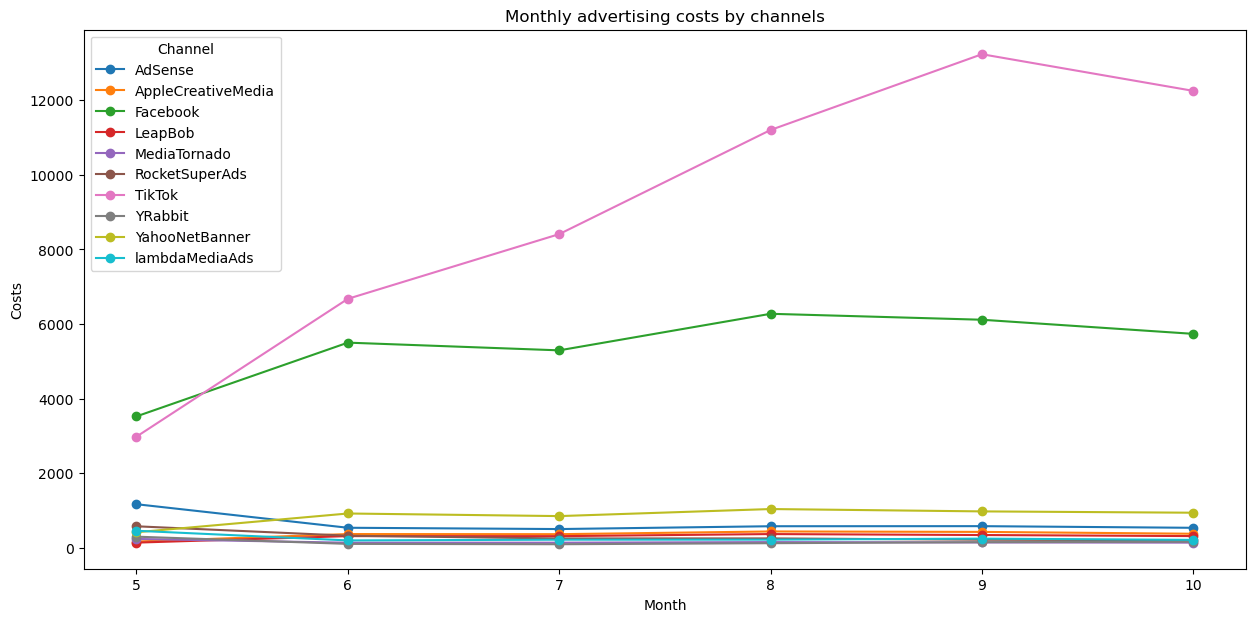

In [115]:
# Creating a graph for each channel for monthly advertising costs
fig, ax = plt.subplots(figsize=(15, 7))

for index, row in monthly_ad_cost_by_channel.iterrows():
    ax.plot(monthly_ad_cost_by_channel.columns[1:], row[1:], marker='o', label=row['channel'])

# Settings of the graphics
plt.title('Monthly advertising costs by channels')
plt.xlabel('Month')
plt.ylabel('Costs')

# The display of the legend
plt.legend(title='Channel', loc='upper left', bbox_to_anchor=(0, 1))

plt.show()

- As shown in the monthly dynamics TikTok ads cost growth is even more obvious

### Let's find the average CAC for users from each channel

channel  user_count  acquisions_cost_total  average_acq_cost
0               TikTok       19561               54751.30          2.799003
1             Facebook       29144               32445.60          1.113286
2              AdSense        3880                3911.25          1.008054
3       lambdaMediaAds        2149                1557.60          0.724802
4       YahooNetBanner        8553                5151.00          0.602245
5       RocketSuperAds        4448                1833.00          0.412095
6   AppleCreativeMedia        8605                2151.25          0.250000
7              YRabbit        4312                 944.22          0.218975
8         MediaTornado        4364                 954.48          0.218717
9              LeapBob        8553                1797.60          0.210172
10             organic       56439                   0.00          0.000000

The average CAC of the entire project: 0.7032778251826568


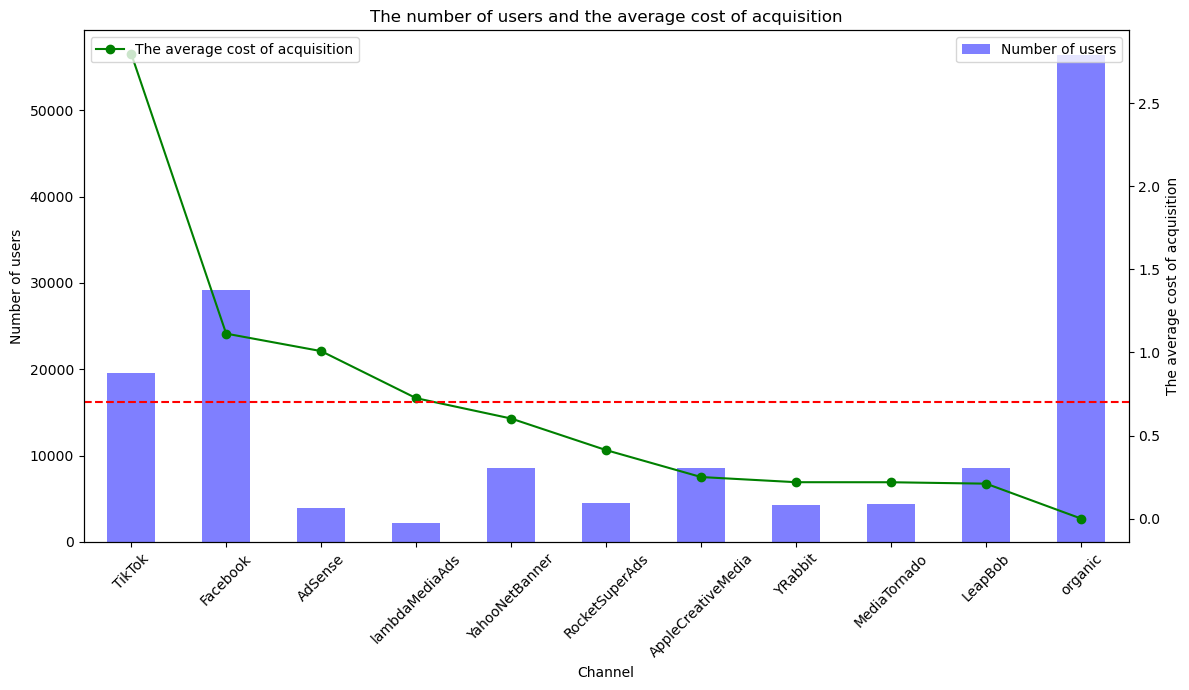

In [116]:
average_acquisition_cost_per_channel = profiles.groupby('channel').agg({'user_id':'count', 'acquisition_cost':'sum'})

average_acquisition_cost_per_channel['average_acq_cost'] = average_acquisition_cost_per_channel['acquisition_cost'] / average_acquisition_cost_per_channel['user_id']
average_acquisition_cost_per_channel.columns = ['user_count','acquisions_cost_total','average_acq_cost']
average_acquisition_cost_per_channel = average_acquisition_cost_per_channel.sort_values(by='average_acq_cost', ascending=False).reset_index()
display(average_acquisition_cost_per_channel)

total_average_CAC = profiles['acquisition_cost'].mean()
print('The average CAC of the entire project:', total_average_CAC)

fig, ax1 = plt.subplots(figsize=(12, 7))

# Building bars for number of customers and average CAC
average_acquisition_cost_per_channel[['user_count']].plot(kind='bar', ax=ax1, width=0.5, color=['blue'], legend=False, alpha=0.5)

# Setting the axes
ax1.set_ylabel('Number of users')
ax1.set_xlabel('Channel')
ax1.set_xticklabels(average_acquisition_cost_per_channel['channel'], rotation=45)
ax1.set_title('The number of users and the average cost of acquisition')

# Creating the second axis Y for graphics with Ratio
ax2 = ax1.twinx()

ax2.plot(average_acquisition_cost_per_channel['average_acq_cost'], marker='o', color='green')
ax2.axhline(y=0.7, color='red', linestyle='--')
# Setting the second axis Y
ax2.set_ylabel('The average cost of acquisition')
ax1.legend(['Number of users'], loc='upper right')
ax2.legend(['The average cost of acquisition'], loc='upper left')

plt.tight_layout()
plt.show()

- The highest average cost of acquisition (CAC) goes to TikTok - **2.79**, the number of users is less than the FaceBook channel, whichs also has much lower average cost of acquisition  - **1.11**
- Relatively high average CAC (**1.00 and 0.72**) goes to AdSense and Lambdamediaads channels, with very few users acquired
- Yahoonetbanner channels, AppleCreativeMedia and Leapbob show low average CAC (less than **0.6**) and decent amounts of attracted users

### Conclusions on the distribution of users by countries, channels, device types, the effectiveness of investing in advertising in various channels

1. According to the total number of users the United States is far ahead - 100 thousand against 15-18 thousand in other countries.The level of paying users in the United States is also the largest - 6.9% against 4% in other countries, which suggests that ** the US is the most "selling" market for us (we will evaluate the profitability of markets later)
2. France, Germany and the UK show more modest results in terms of the users count and the share of paying is 4% - **perhaps we should work on increasing the number of customers in these countries using advertising.**
3. The percentage of organic users in all countries at the level of 36-38%, which indicates the absence of anomalies in attracting users in countries (exposure of the application to market)
4. There are cardinal differences in the advertising channels selection in the USA and other countries: in the USA we advertise mainly on TikToc & Facebook and a couple of other channels, at the same time in other countries Facebook & Tiktoc are not used at all, other channels are also different from the US market.**We should consider Facebook & Tiktoc as advertising channels for Europe to get more market penetration**
5. According to the devices usage - the most rewarding users are using iPhone & Mac (more than 6% paying), second place Android (5.85%), but PC users do not really like to spend money (5.05%).**It is worth focusing on advertising to attract users with Mac, iPhone, Android (in decreasing order) to maximise ROI**.
6. The average percentage of all paying users - 5.92%
- Organic, 56 thousand, the share of paying among them is the lowest: 2.06%
- Facebook, 30 thousand users, the share of paying is the highest among all channels - 12.2%
- Tiktok, 20 thousand users. The share of the paying is also high - 9.6%
- The rest of the channels show much more modest results both in the number of acquired users (2-9 thousand) and the percentage of paying (less than 4% of AppleCreativeMedia, LEAPBOB, MEDIATORNADO, YRABIBIT)
- While being small in the number of acquired customers, Lambdamediaads stand out with a large share of payers - more than 10%.

**As a recommendation, it is worth considering  increasing the conversion of Organic clients to paying users (some special offers for them etc.), increase investments in advertising on the Lambdamediaads channel, where there are a large share of payers, add advertising on Facebook & Tiktok in Europe**.

7. Advertising costs and revenue through the channels:
- First place in terms of costs and revenue - the Tiktok channel with the ROI ratio - 127%
- Second place by revenue is Organic channel - customers who came by themselves. Advertising costs = 0
- Third place by revenue - Facebook, but with negative ROI - 79%, i.e. we spend more on advertising than we earn.
- The remaining channels, although they show more modest revenue results, have a much higher revenue/cost ratio - 400% and higher.**It is worth considering them for advertising in the USA**.
- Judging by the monthly dynamics, our advertising costs on Tiktok are growing too fast. Next, we will study the profitability of these investments

## ROI and LTV analysis

### We will analyze the payback of advertising expences using the LTV and ROI graphs leaving only paying users for an analysis

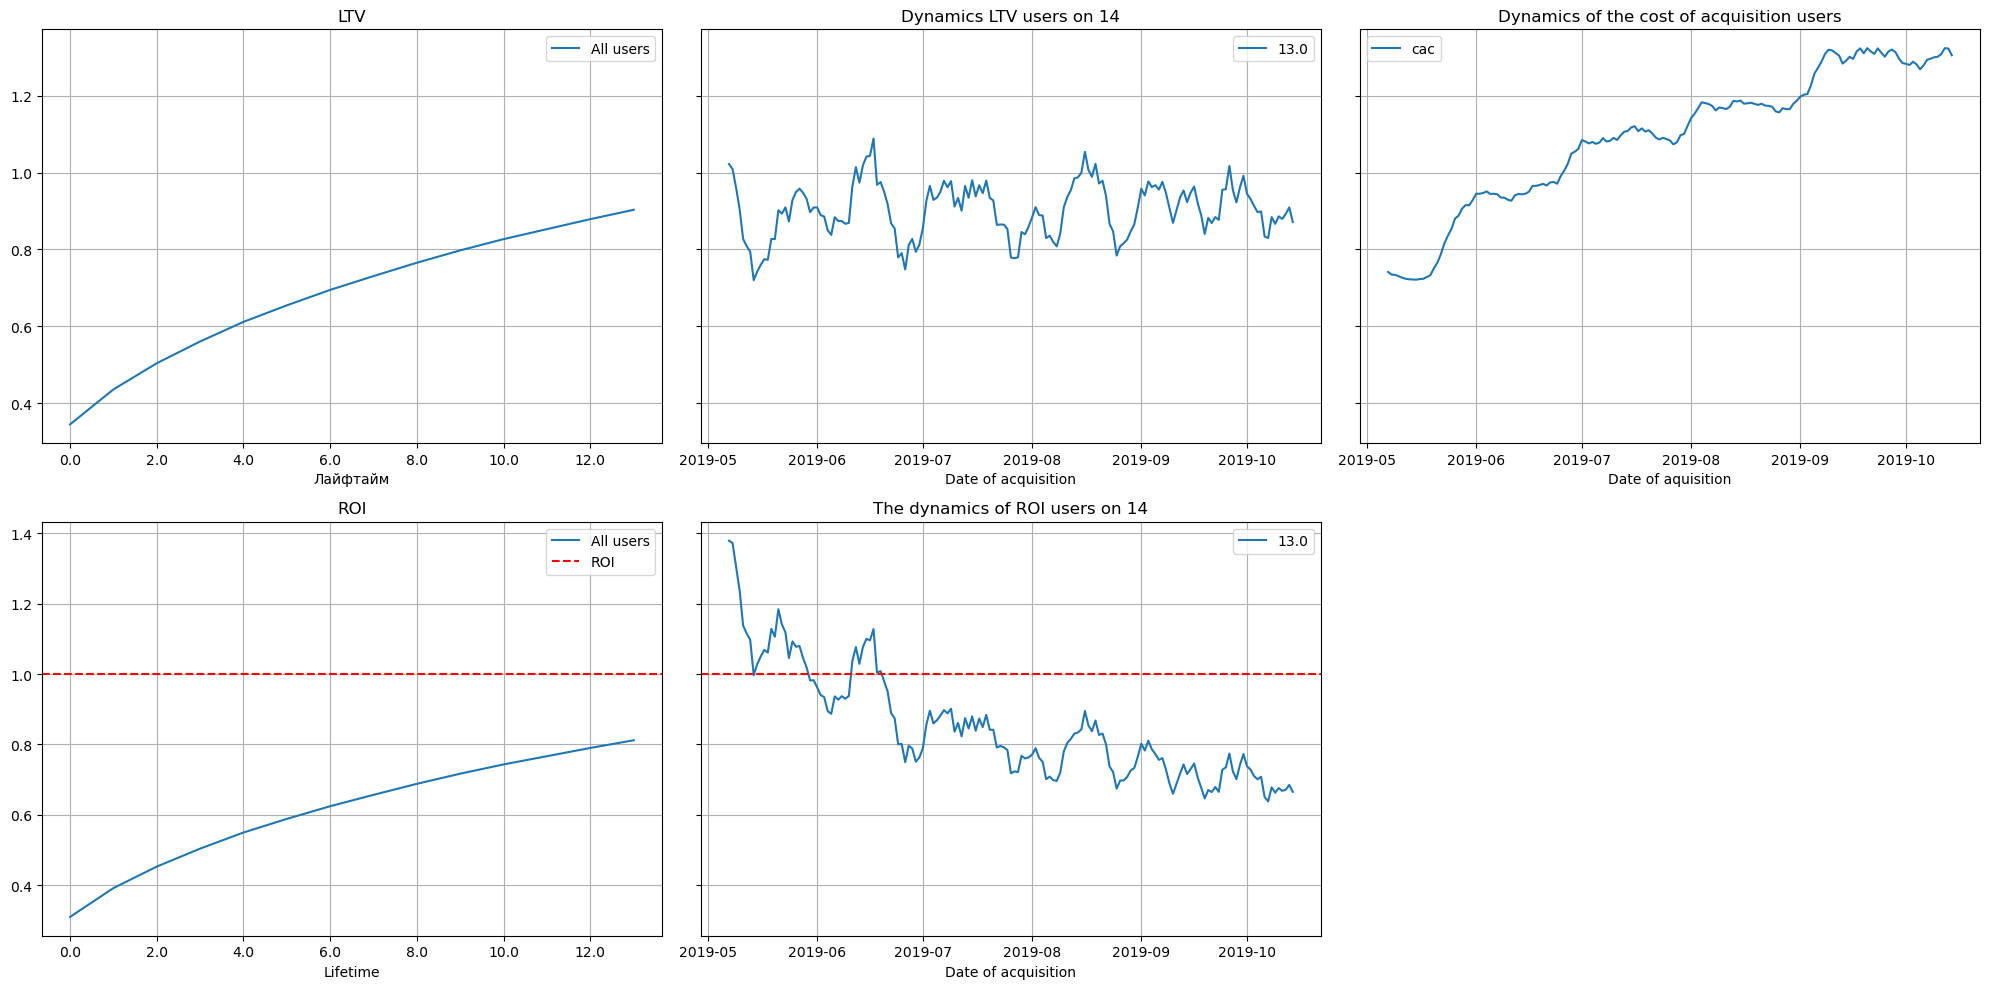

In [117]:
observation_date = dt.datetime(2019, 10, 27).date()  # The moment of analysis is the maximum date in the reports about the acquisition - 10/27/19
horizon_days = 14  # Analysis horizon, the goal for break-even point is 2 weeks

# Leave only paying users in profiles
profiles_from_ad = profiles.query('channel != "organic"')

# LTV and ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_from_ad, orders, observation_date, horizon_days
)

# build graphs
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

- We are not getting into target break-even point: ROI at the end of 14 days - about 80%, i.e. our profit from users acquired by ads does not even cover the costs.
- The dynamics of ROI show positive values ​​at the beginning of the period (May-June), but then goes down below the level of profitability
- CAC grows all the time. Maybe, our advertising budget is ineffectively spent.
- LTV for 2 weeks is about 0.8
- The seasonal factor affects LTV, but this indicator is quite stable.

### Let's look at the performance indicators by countries

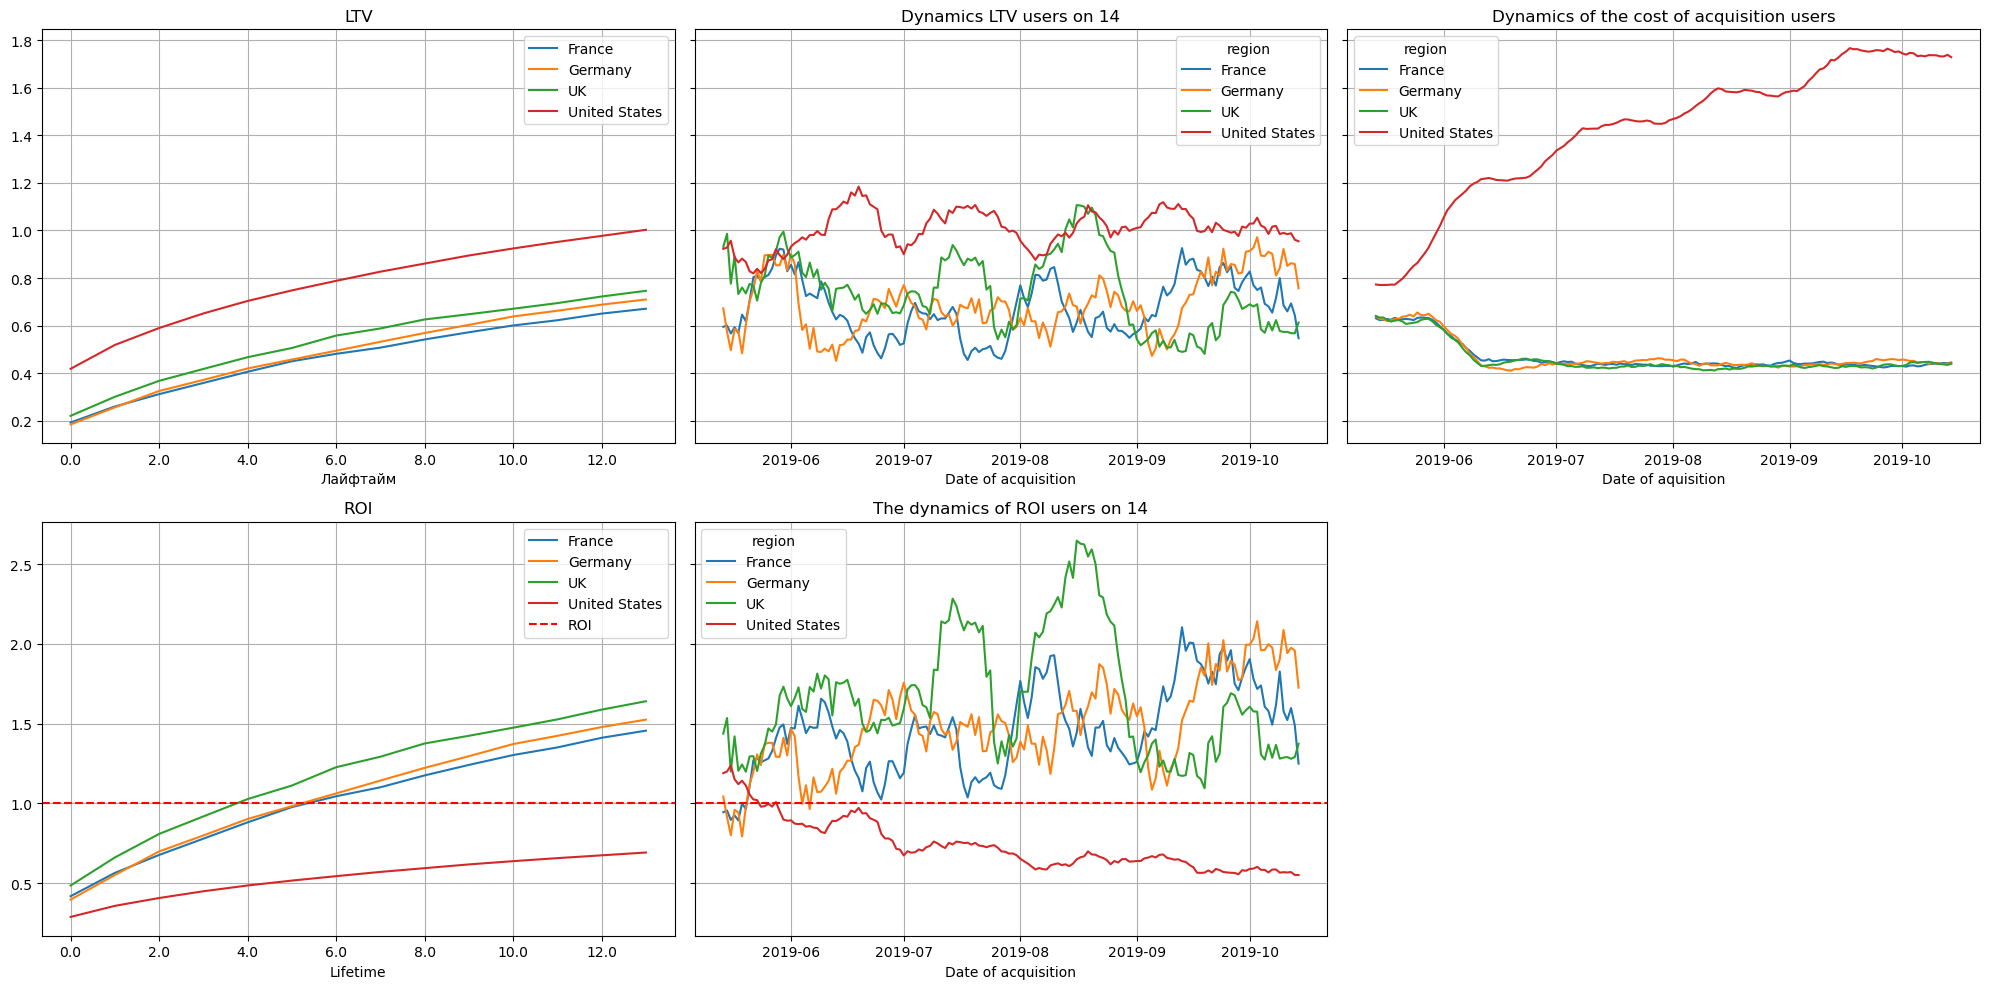

In [118]:
# Lets see a breakup by countries 

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- LTV for 2 weeks is about 0.7 for Europe, for the United States above - about 1. We get more from US users in general but - 
- ...advertising in the USA does not pay off. ROI at the end of 14 days - about 70%, while in Europe, payback at 150%
- ROI dynamics show positive dynamics ​​in Europe, but in the USA starting in June - goes down to the level of 50%, i.e. revenue totally fails to cover ads expences in USA. .
- And on opposite CAC for USA is growing all the time - seems like we put all the money into one market
- LTV dynamics is stable for all countries and shows only seasonal fluctuations

### Markers by channels

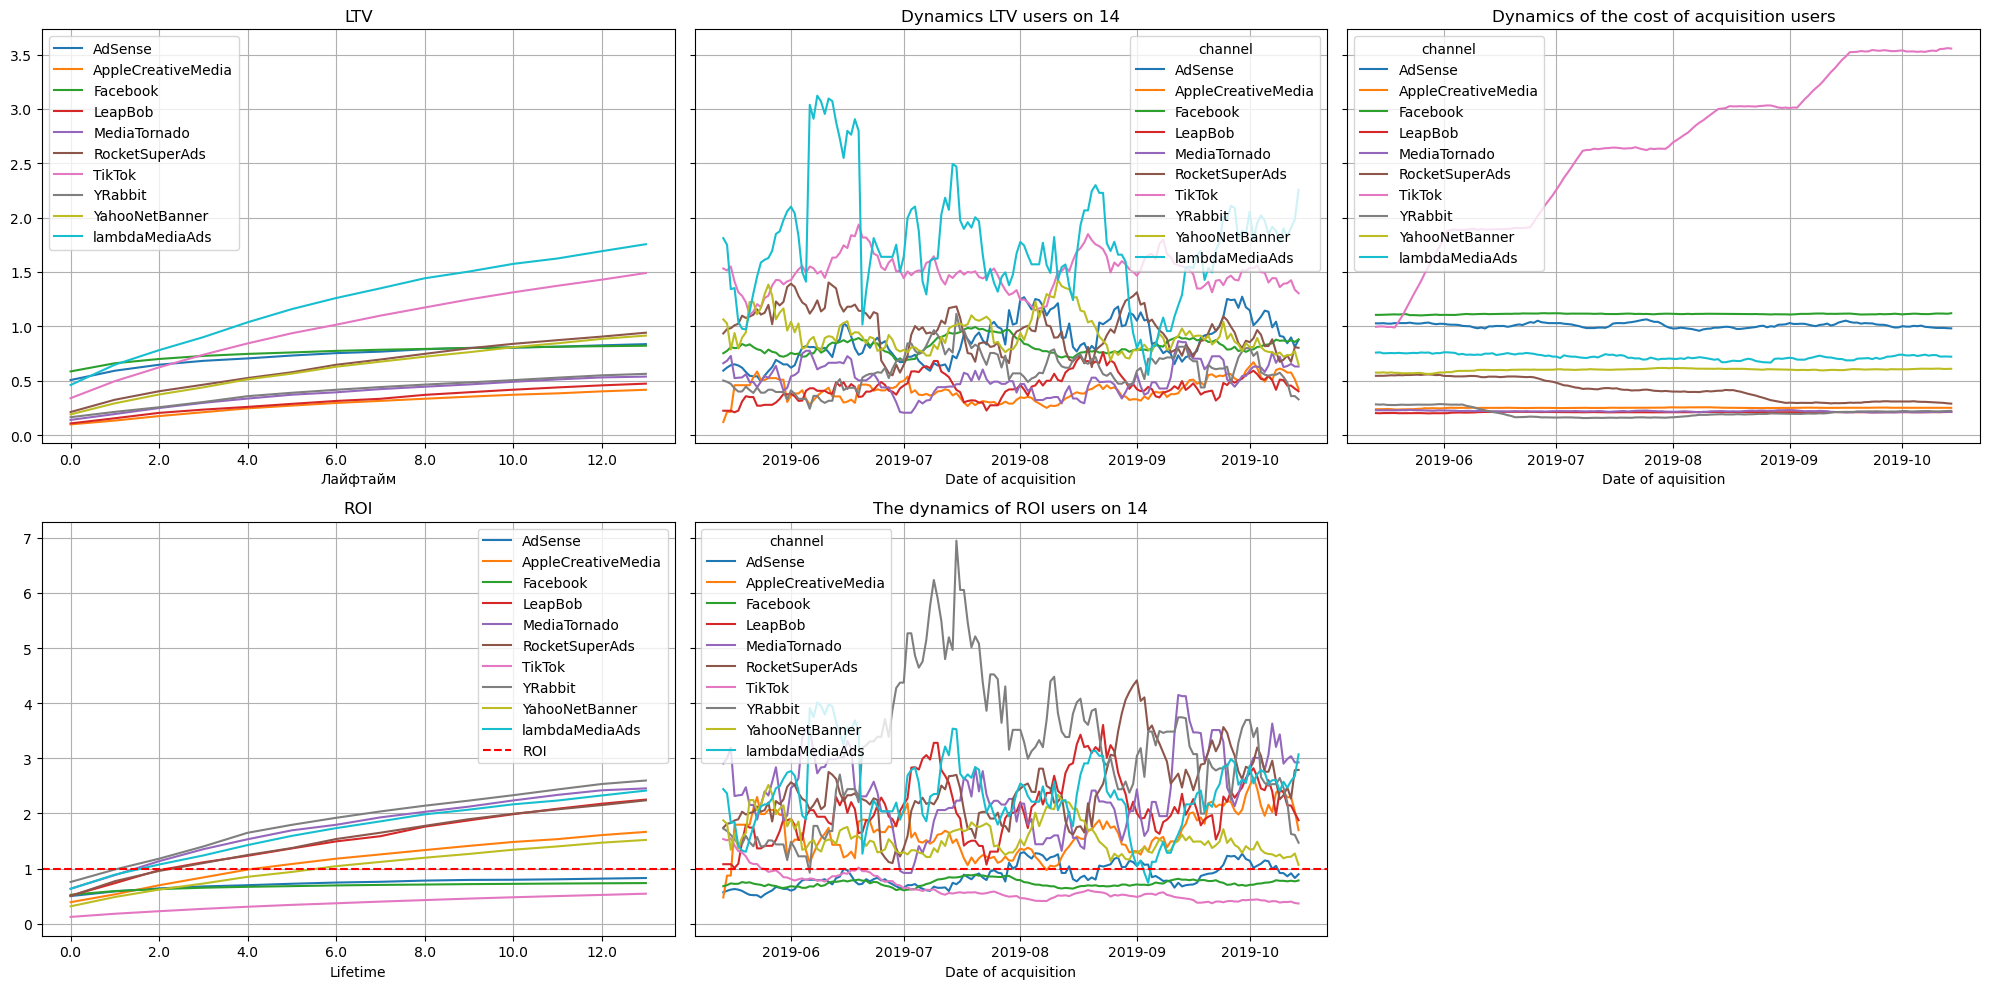

In [119]:
# We can see the ROI with breakdown by channels

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- LTV for users from AdSense & Tiktok channels - about 1.5, LTV of the rest - in the 0.5 - 1 range
- The dynamics of LTV is stable and shows seasonality
- ROI in the main (by expenses and the number of users) advertising channels  - Tiktok & Facebook - below the payback threshold - 60-70%. The remaining channels show ROI above 100%
- Basically these 3 channels are **below the payback level:**
1. **Tiktok**
2. **Facebook**
3. **AdSense**

- ROI dynamics through the channels: Facebook since May has been at 70-80% level, Tiktok has gone below 100% since June and reached 50% by the end of October, while the following channels show growth by October:
- Mediatornado (300%)
- Lambdamediaads (200%)
- AppleCreativeMedia (200%)
- CAC dynamics shows the monthly growth of Tiktok channel expenses - from 1.0 in May to 3.5 in October, while the CAC of the remaining channels is stable. Obviously, our investments in advertising on Tiktok do not pay off and continue to grow.

### Markers by device types

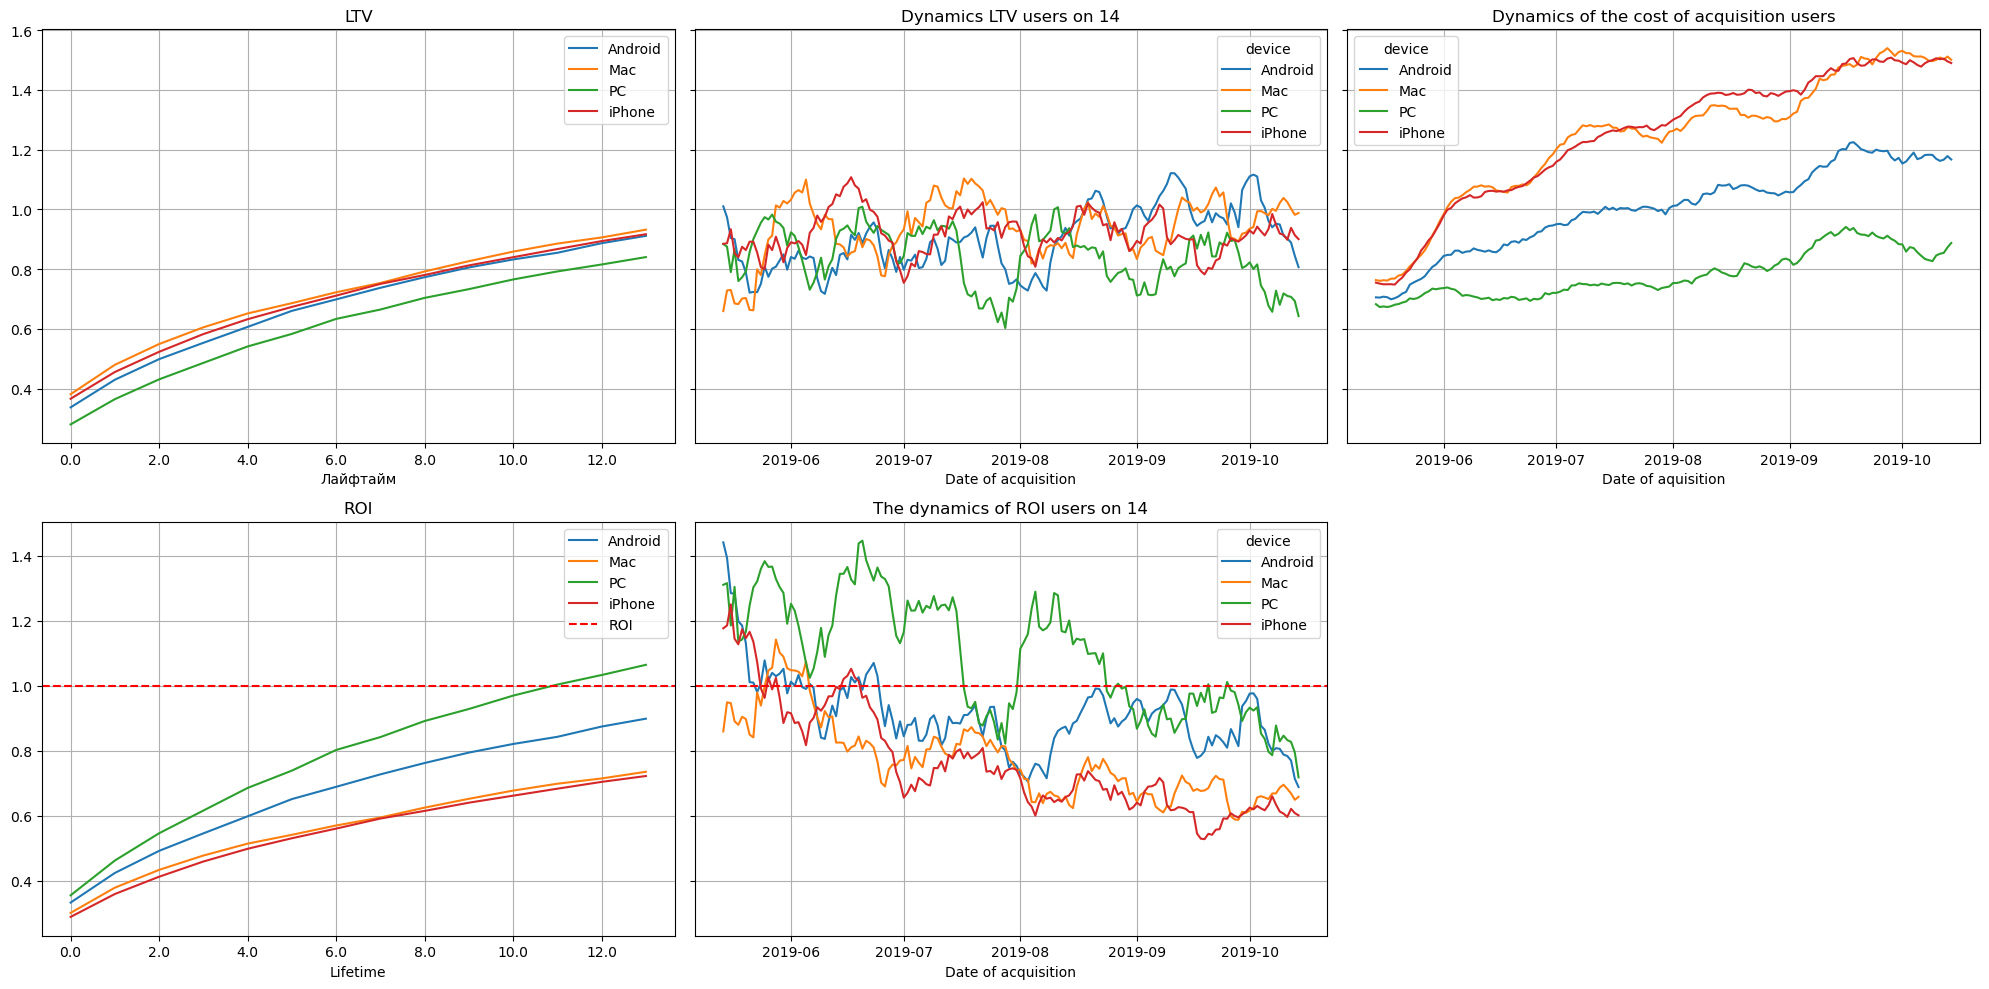

In [120]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

- LTV of PC users are lower than the rest, although the ROI is higher than 100% threshold, while other devices ROI is below 100%. Apparently, we get to break-even point by the end of 14 day with PC users only.
- The ROI dynamics in all devices shows a fall - by October it dropped below 80%, while in May it was positive.This suggests that CAC is growing for all devices.
- CAC dynamics shows the monthly increase in the cost of attracting iPhone users, Mac - from 0.8 in May to 1.5 in October, at that time, Adroid - from 0.7 to 1.2, RS - from 0.65 to 0.9

### How does the conversion of users with a breakdown on devices looks like

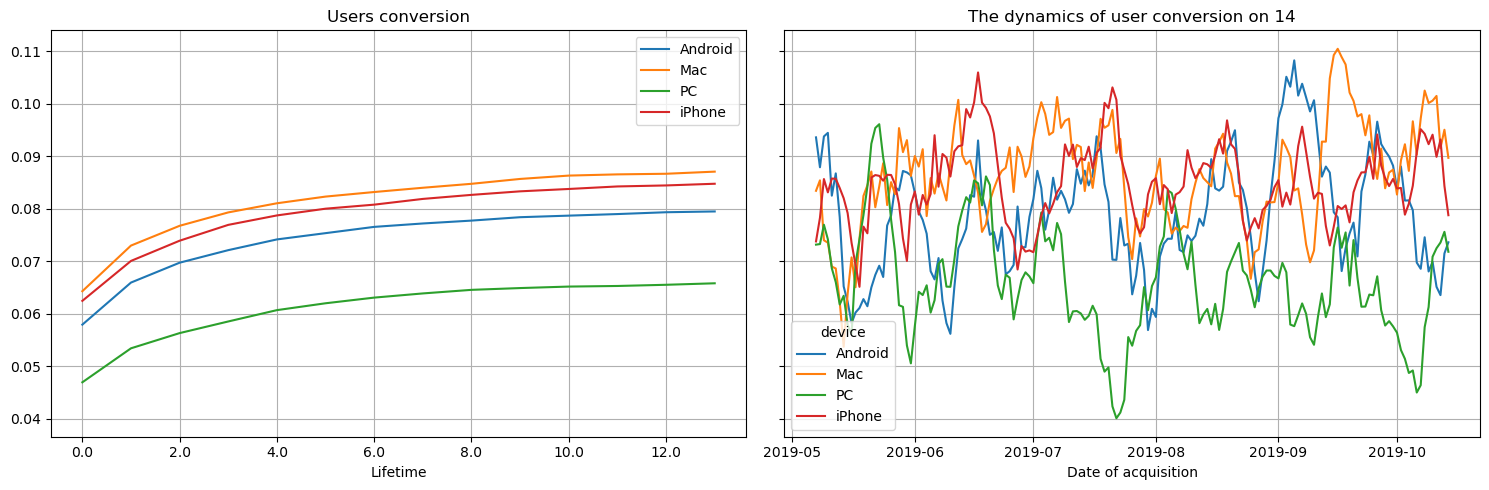

In [121]:
# We see a conversion with a breakdown by devices
dimensions = ['device']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Mac & iPhone user conversion is the largest, PC in lowest
- The dynamics of the conversion is stable and shows seasonality

### How does the conversion with a breakdown by a country look like 

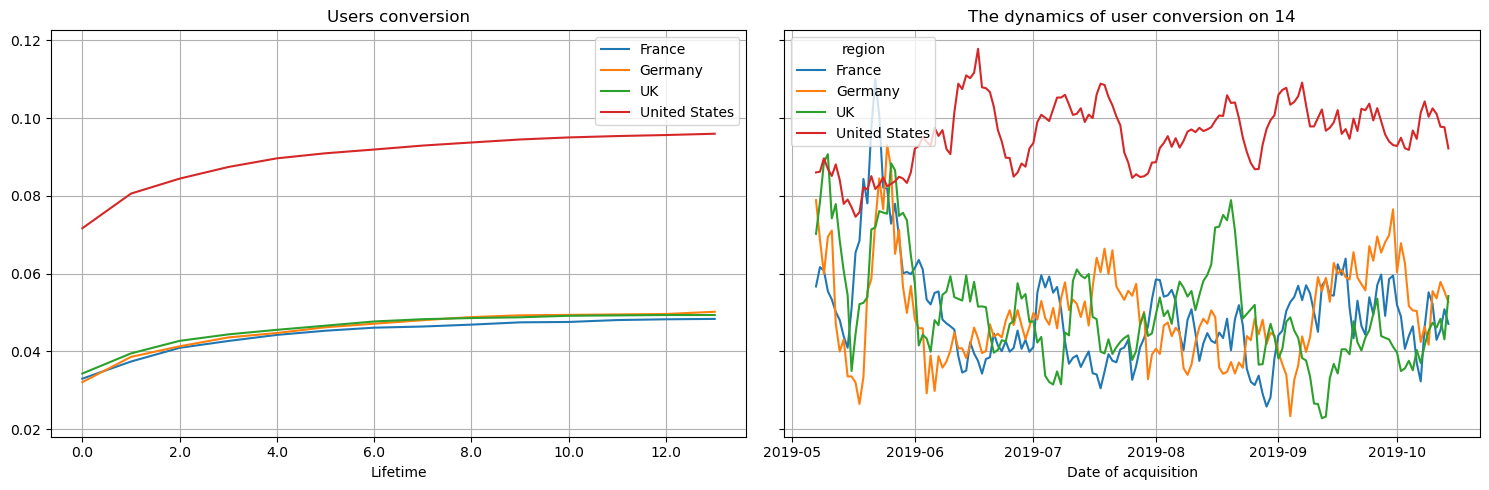

In [122]:
dimensions = ['region']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Users from the USA have conversion 2 times better than from Europe
- In May, there was a moment when the conversion of European users was higher than from United States users, but then the United States is leading. Seems like our ads or product promotion strategy looks different in USA from June onwards.

### How does the conversion with a breakdown by acquisition channels look like

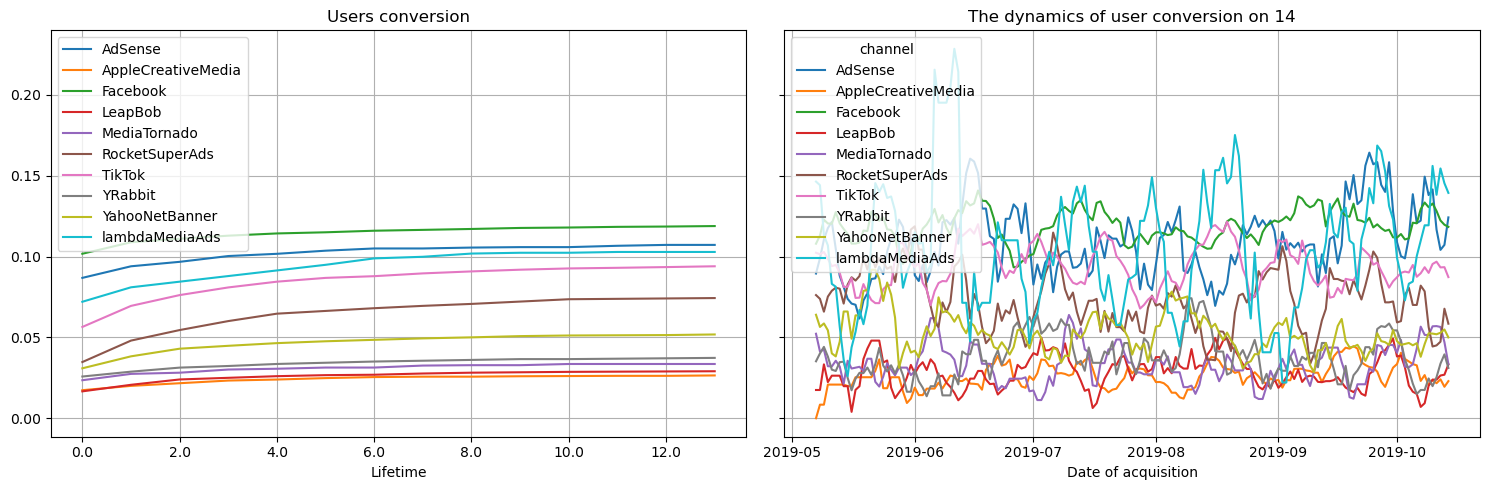

In [123]:
dimensions = ['channel']
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_from_ad, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

- Conversion in Facebook channels, AdSense & Lambdamediaart is the best, and Tiktok, where we are constantly investing, gets only 4th place.

### Let's look at the retention with a breakdown by countries

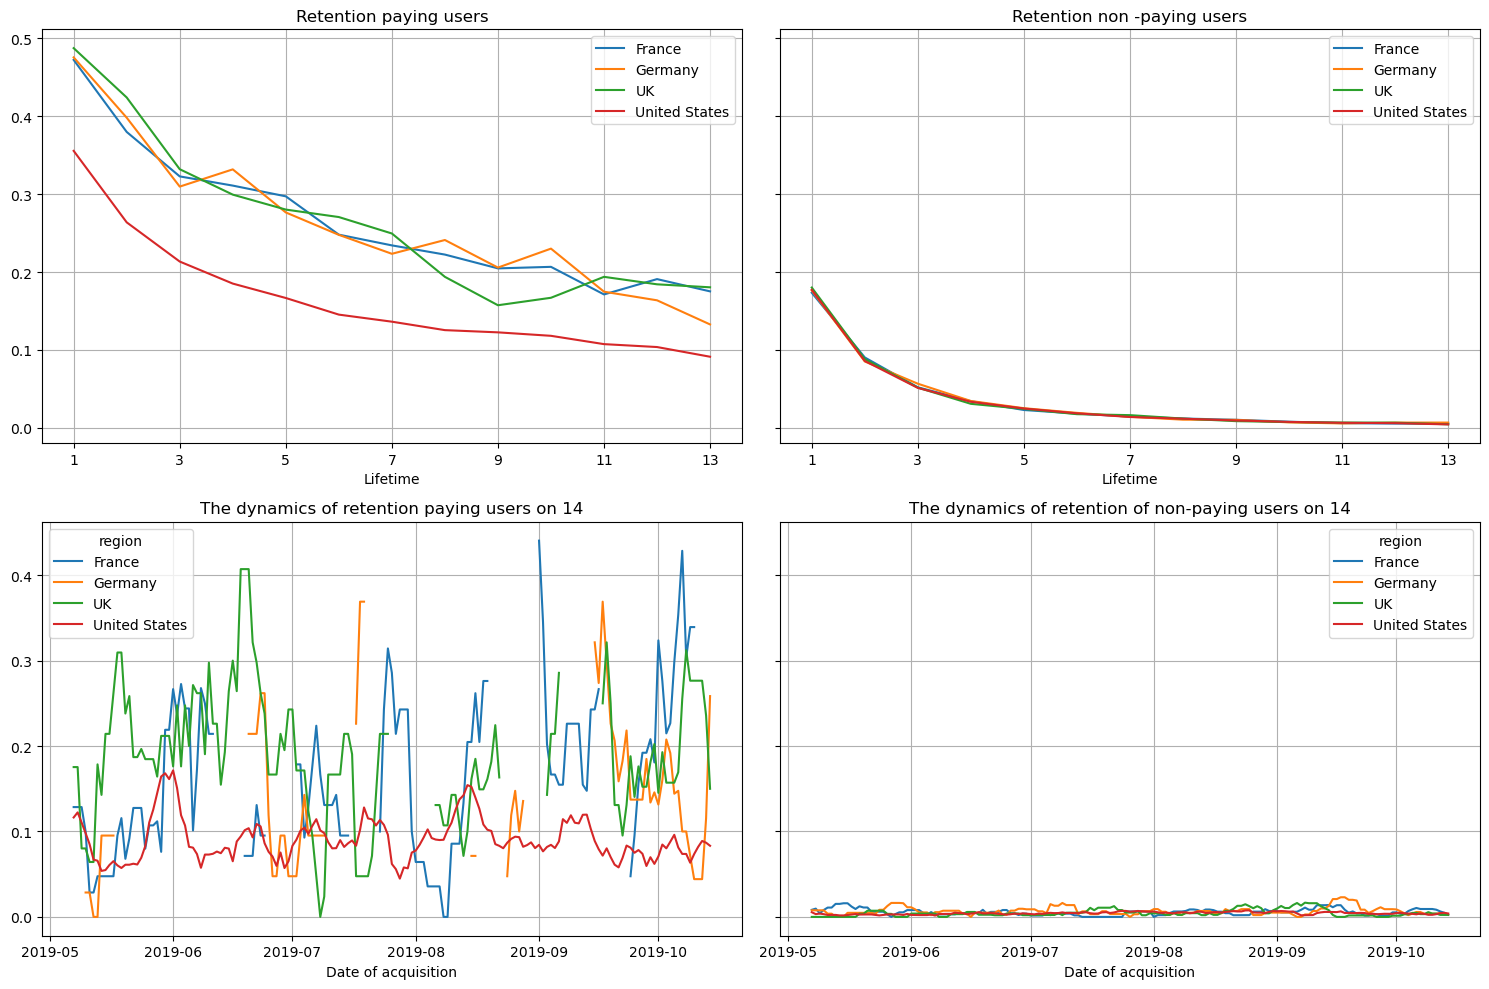

In [124]:
dimensions = ['region']
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_from_ad, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Paying users retention on the 14th day in the United States is significantly lower than in Europe
- The dynamics of paying users retention in the United States shows less fluctuations than in Europe - lower but more stable.


### Let's look at the retention with a breakdown by channels

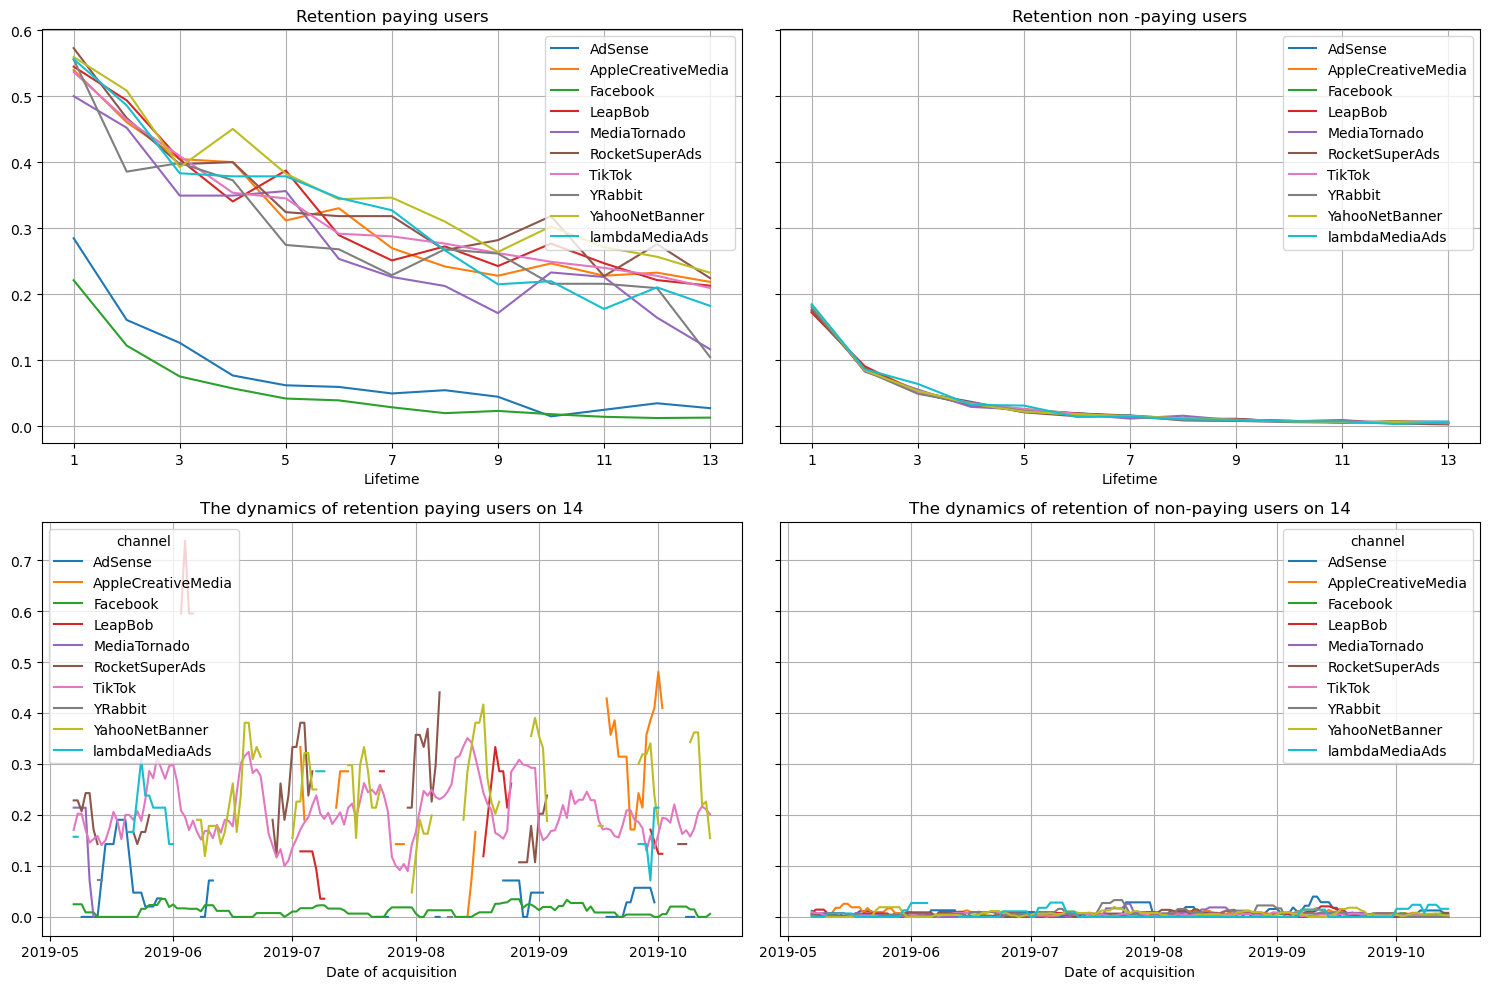

In [125]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_from_ad, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

- Facebook & AdSense have lowest retention despite the fact that the conversion of these channels is the highest.

### Let's look at the retention with a breakdown by devices

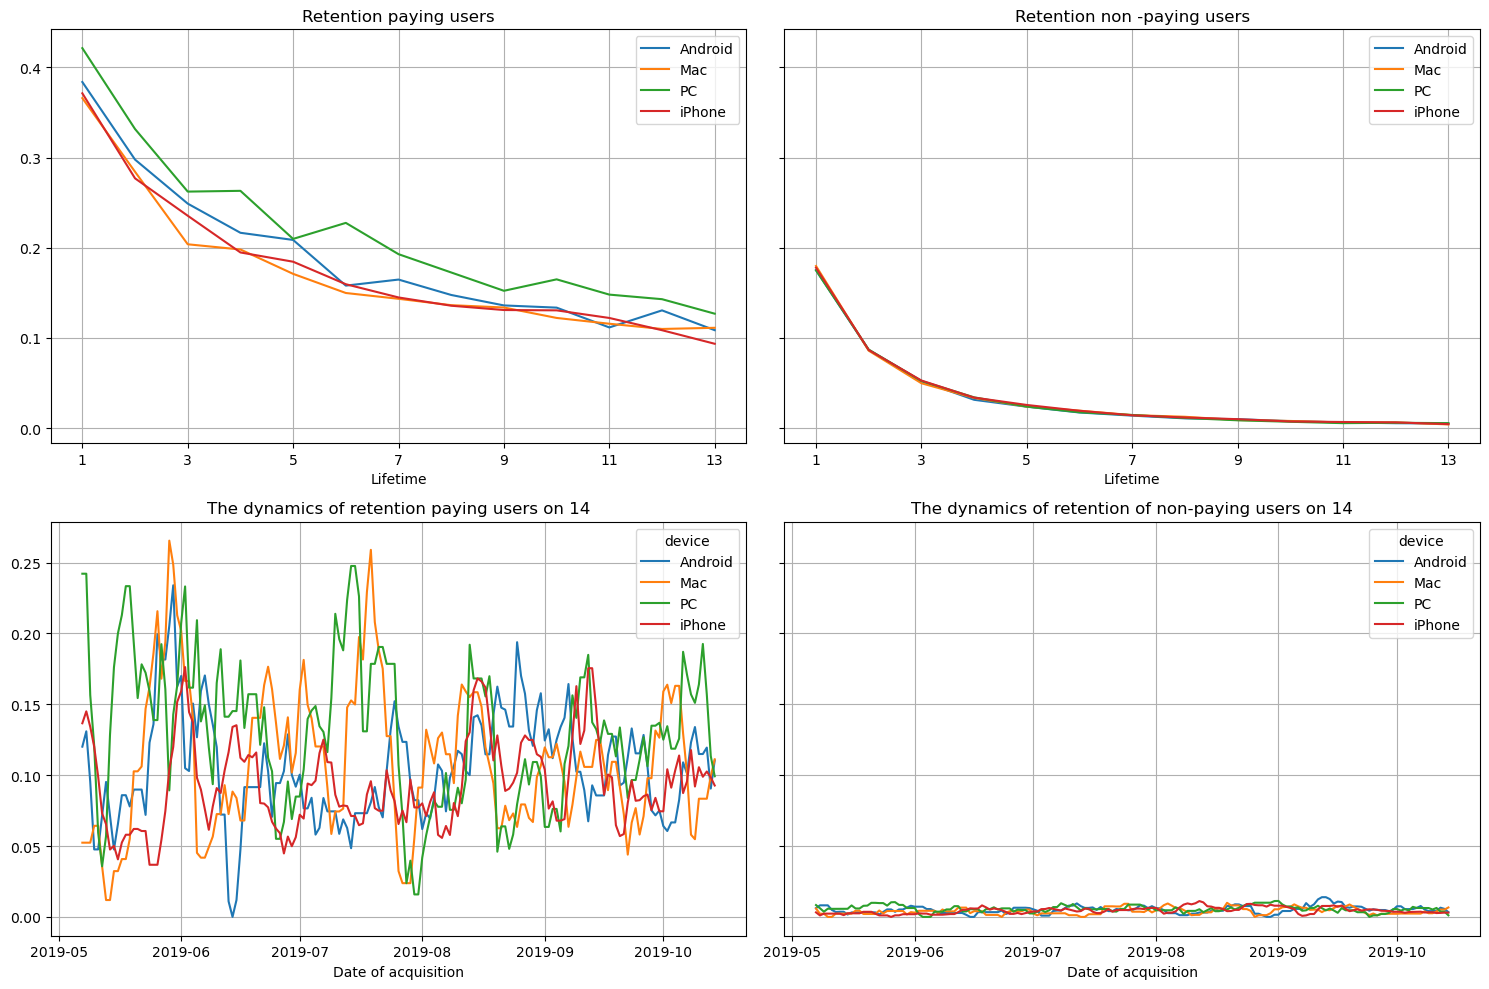

In [126]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_from_ad, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

- There are no anomalies in the devices retention rates so far


# Conclusions

During the analysis of the advertising investments for the Procrastinate Pro+ app, we conducted an exploratory data analysis (EDA), standardized column names and data types, calculated the number and percentage of paying users, compiled user profiles, and measured user metrics, including LTV, CAC, and ROI.

**Below are our conclusions:**

# Causes of Inefficiency in Advertising Investments

## Low Conversion Rate (CR):
- Analysis shows that the conversion rate of PC and Android users in Europe is half that of users in the USA.
- The 14-day conversion curve is too flat — it reaches 10% by day 7 and then plateaus, after which users begin to leave the app, as shown by the churn data.

## Low Retention Rate (RR):
- Retention among paying users is below 60% by the second day and continues to decline to 10%, suggesting potential issues with app functionality or insufficient user engagement.
- Retention is particularly low among U.S. users acquired through Facebook and AdSense, as illustrated in the retention graphs.

## LTV, ROI, CAC Metrics:
- The acquisition cost for iPhone and Mac users is rising faster than for Android and PC users.
- Only PC users have an ROI above 100% after 14 days; all other segments remain below the breakeven threshold.
- CAC for TikTok surged from 1.0 in May to 3.5 in October, while CAC from other channels remained stable. Clearly, our TikTok ad investments are not yielding a return and continue to increase.
- Key channels, Facebook and TikTok, which drive the highest user volume, remain below the ROI breakeven point, with returns of only 60-70%.
- Spending on U.S. user acquisition continues to increase, yet ROI reaches only 50% by day 14, while in Europe ROI reaches 100% by day 6 and peaks at 150% by day 14.
- LTV in the U.S. is higher than in Europe, but not sufficient to cover the CAC.

# Recommendations for the Marketing Department

## Improve Conversion
- We should intensify advertising efforts in Europe; brand visibility may be lacking due to limited presence on Facebook and TikTok, or the app may lack market-specific features, or there may be payment-related challenges in Europe.
- Enhancing user motivation to make purchases within the first 14 days could be achieved through time-limited special offers, newsletters, etc.

## Improve Retention
- Increase user engagement with product updates, discounts, bonuses, and loyalty programs, focusing especially on U.S. users acquired through Facebook.
- Solicit and act on user feedback to improve the app experience.
- Maintain active user engagement to reduce churn.

## Adjust Advertising Strategy
- Use Facebook and TikTok in Europe to attract new customers and build brand recognition.
- While our primary revenue comes from iPhone and Mac users, advertising should also target improved conversion among Android and PC users.
- We should reallocate U.S. ad spend from TikTok to channels with proven conversion and retention rates